# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 71 (delta 13), reused 59 (delta 9), pack-reused 3
Unpacking objects: 100% (71/71), 50.91 MiB | 9.18 MiB/s, done.
Processing ./deepul
  Preparing metadata (setup.py) ... done
  Created wheel for deepul: filename=deepul-0.1.0-py3-none-any.whl size=12109 sha256=3aca9c5409d84e932832e21000040f2c881d44c0539cecb341591621b04d38e6
  Stored in directory: /tmp/pip-ephem-wheel-cache-vi2zwvu6/wheels/9f/87/5f/ef5f733d44a17a7cf0ffd7382ffa4226a1ad875648c2363506
Successfully built deepul
  Attempting uninstall: deepul
    Found existing installation: deepul 0.1.0
    Uninstalling deepul-0.1.0:
      Successfully uninstalled deepul-0.1.0


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd.profiler as profiler

import time
import math
import copy
from functools import partial
from tqdm import tqdm

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


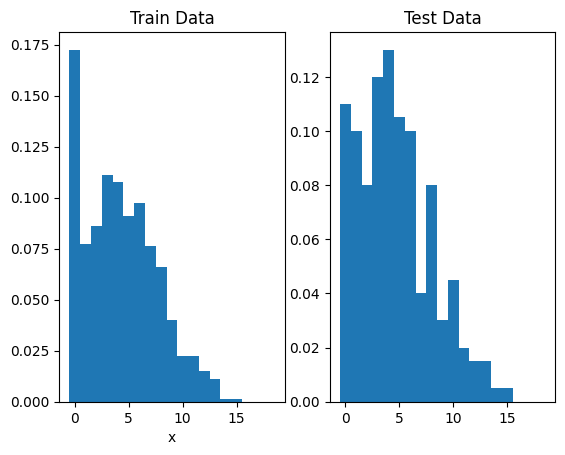

Dataset 2


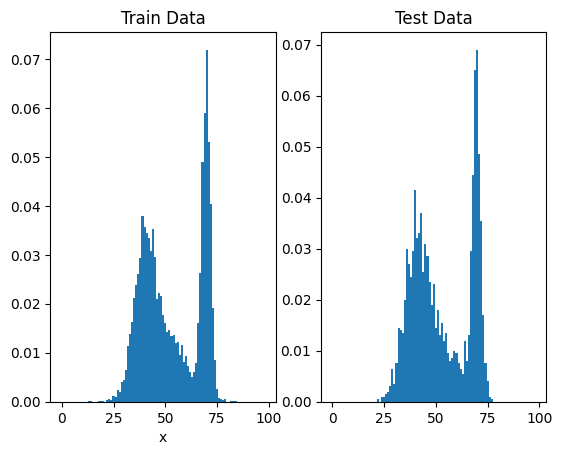

In [ ]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{d-1}) \in \mathbb{R}^{d}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,d-1\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

### Q1a NLL and train script

In [15]:
def q1a_nll(x, theta):
    """
    Compute avg negative log likelihood:
    1/N \sum_x - log p_theta(x) = 1/N \sum_x [-theta_x + LSE(theta_0, ..., theta_d-1)]

    Args:
    x: (num_samples,) np.ndarray of integers in {0, ..., d-1}
    """
    num_samples = x.shape[0]
    return -theta[x].mean() + torch.logsumexp(theta, dim=0)


def q1_batch(data, batch_size):
    idx = torch.randperm(data.shape[0])
    batches = torch.split(data[idx], batch_size)
    return batches


def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    num_epochs = 1000
    batch_size = 500
    theta = torch.zeros(d, requires_grad=True)
    optimizer = torch.optim.Adam([theta], lr=1e-3)

    train_data = torch.from_numpy(train_data)
    test_data = torch.from_numpy(test_data)

    num_batches = len(q1_batch(train_data, batch_size))
    train_losses = np.zeros((num_epochs, num_batches))
    test_losses = np.zeros(num_epochs + 1)

    # compute initial test loss
    with torch.no_grad():
        test_losses[0] = q1a_nll(test_data, theta)

    for epoch in range(num_epochs):
        batches = q1_batch(train_data, batch_size)
        train_loss_total = 0
        # compute the negative log likelihood for every minimatch
        # followed by sgd on theta
        for i, b in enumerate(batches):
            optimizer.zero_grad()
            loss = q1a_nll(b, theta)
            loss.backward()
            optimizer.step()
            train_loss_total += loss.item() * b.shape[0]
            train_losses[epoch, i] = loss.item()
        train_loss_total /= train_data.shape[0]

        # evaluate test loss
        with torch.no_grad():
            test_loss = q1a_nll(test_data, theta).item()
            test_losses[epoch + 1] = test_loss

    # print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')

    # compute probabilities by softmaxing theta
    with torch.no_grad():
        distribution = F.softmax(theta, dim=0).detach().numpy()

    train_losses = train_losses.flatten()
    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.5720


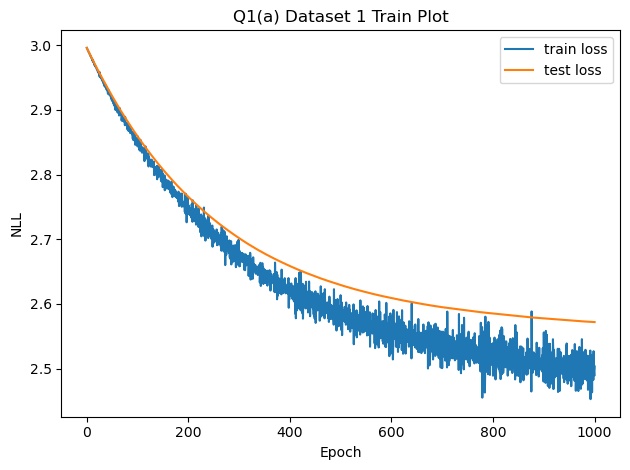

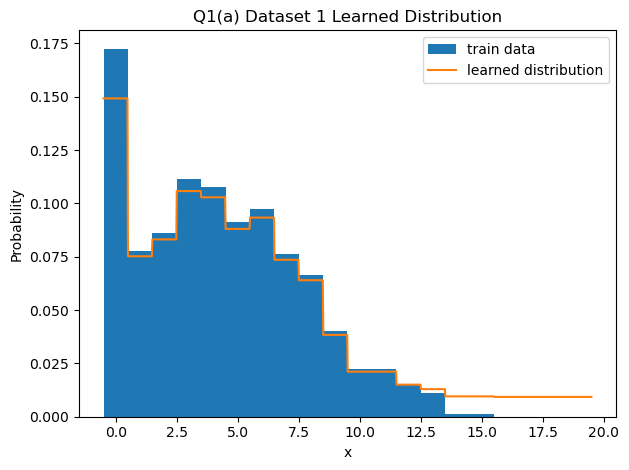

In [16]:
q1_save_results(1, 'a', q1_a)

Final Test Loss: 3.6735


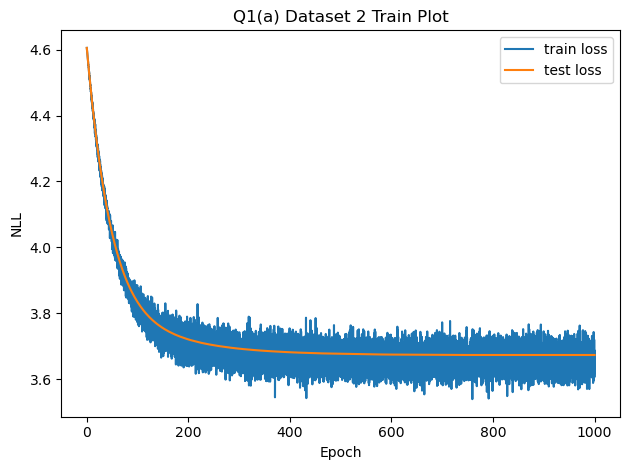

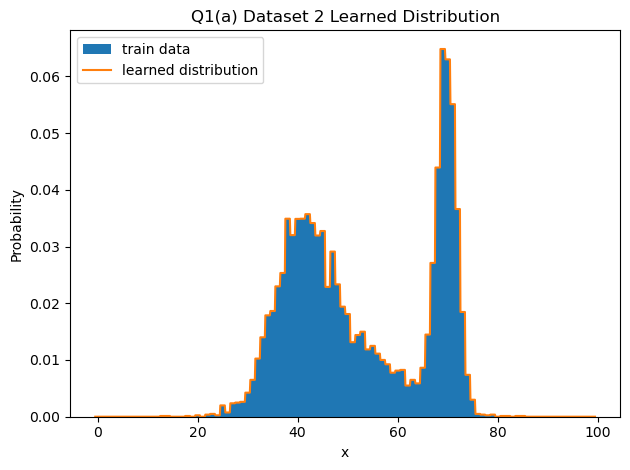

In [17]:
q1_save_results(2, 'a', q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

### Q1b NLL and train script

In [19]:
def q1b_nll(x, pi_logit, mu, s, reduce=True):
    """
    NLL of mixture of logistics
    Return avg. NLL if reduce=True, else return per sample
    N: n_samples, M: n_mixtures

    Args:
    x: torch.tensor(N)
    pi_logit: torch.tensor(M), unormalized mixture assignment probs
    mu: torch.tensor(M)
    s: torch.tensor(M)
    """
    x = x.unsqueeze(1) # (N, 1)
    mu = mu.unsqueeze(0) # (1, M)
    s = s.unsqueeze(0) # (1, M)
    pi = F.softmax(pi_logit, dim=0)
    pi = pi.unsqueeze(0) # (1, M)

    # (N, M)
    components = torch.sigmoid((x + 0.5 - mu) / s) - torch.sigmoid((x - 0.5 - mu) / s)
    # (N,)
    nll = -torch.log((pi * components).sum(dim=1)).squeeze()
    if reduce:
        return nll.mean()
    else:
        return nll

def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
        used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    batch_size = 500
    num_mixtures = 4
    lr = 1e-2

    # initialize mu to where there are more data
    if dset_id == 1:
        mu = torch.zeros(num_mixtures, requires_grad=True)
        num_epochs = 500
    else:
        mu = torch.linspace(25, 75, num_mixtures, requires_grad=True)
        num_epochs = 200
    s = torch.ones(num_mixtures, requires_grad=True)
    pi_logit = torch.zeros(num_mixtures, requires_grad=True)

    optimizer = torch.optim.Adam([mu, s, pi_logit], lr=lr)
    train_data = torch.from_numpy(train_data)
    test_data = torch.from_numpy(test_data)
    num_batches = len(q1_batch(train_data, batch_size))
    train_losses = np.zeros((num_epochs, num_batches))
    test_losses = np.zeros(num_epochs + 1)

    # compute initial test loss
    with torch.no_grad():
        test_losses[0] = q1b_nll(test_data, pi_logit, mu, s)

    for epoch in range(num_epochs):
        batches = q1_batch(train_data, batch_size)
        train_loss_total = 0
        # compute the negative log likelihood for every minimatch
        # followed by sgd on theta
        for i, b in enumerate(batches):
            optimizer.zero_grad()
            loss = q1b_nll(b, pi_logit, mu, s)
            loss.backward()
            optimizer.step()
            train_losses[epoch, i] = loss.item()
            train_loss_total += loss.item() * b.shape[0]
        train_loss_total /= train_data.shape[0]

        # evaluate test loss
        with torch.no_grad():
            test_loss = q1b_nll(test_data, pi_logit, mu, s).item()
            test_losses[epoch + 1] = test_loss

    # print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')

    # compute probabilities by evaluating p_theta(x) at each discrete point x
    with torch.no_grad():
        discretes = torch.arange(0, d)
        nll = q1b_nll(discretes, pi_logit, mu, s, reduce=False) # (d,)
        distribution = F.softmax(-nll, dim=0).detach().numpy()

    train_losses = train_losses.flatten()
    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Final Test Loss: 2.6574


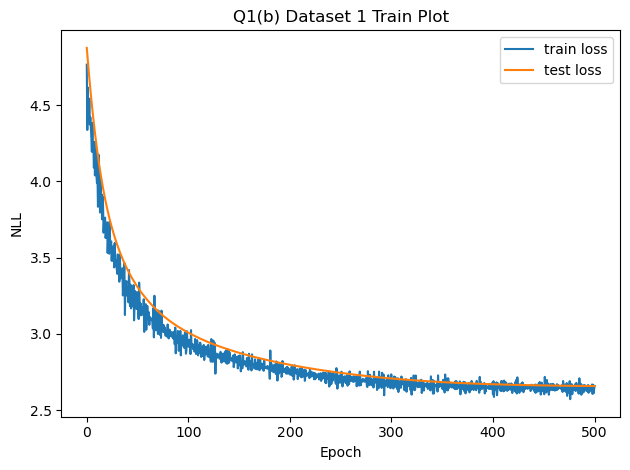

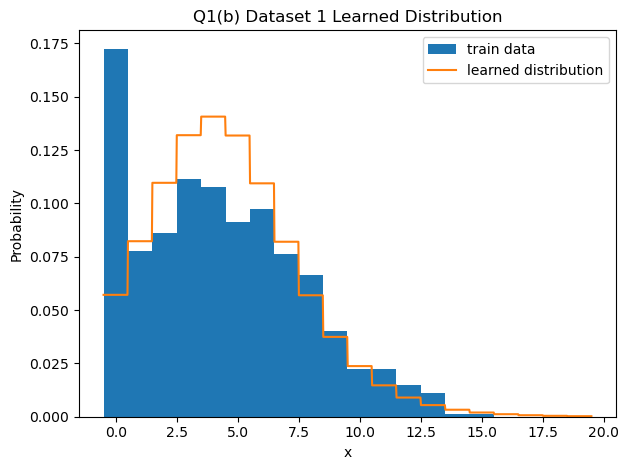

In [20]:
q1_save_results(1, 'b', q1_b)

Final Test Loss: 3.6794


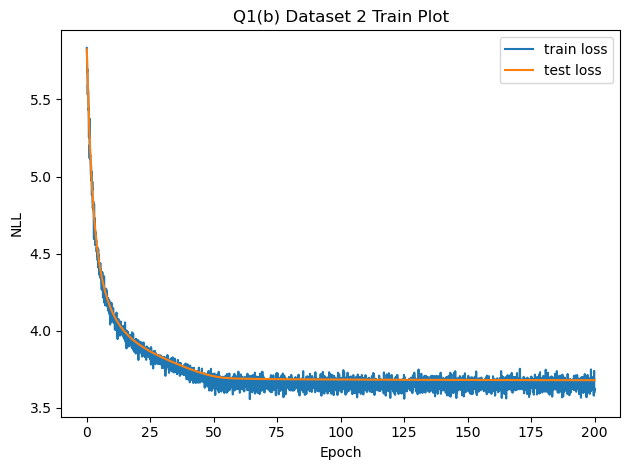

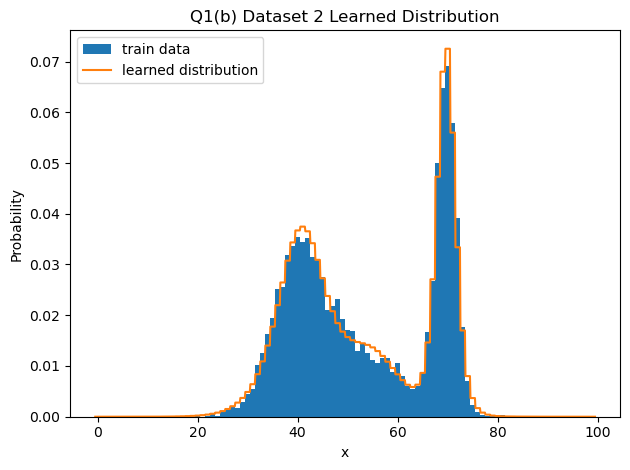

In [21]:
q1_save_results(2, 'b', q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

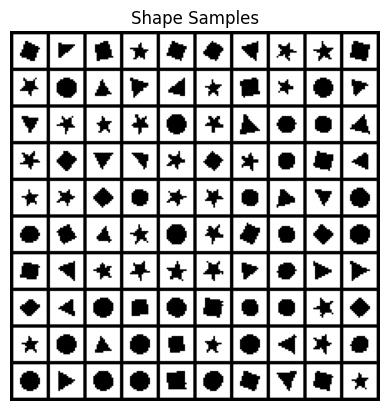

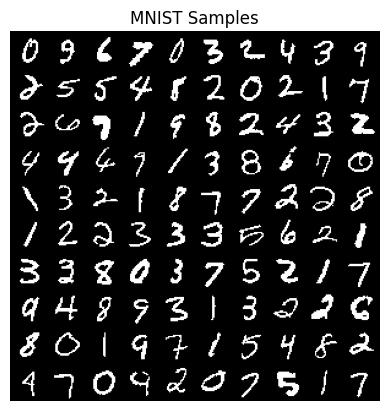

In [33]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network.

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

### PixelCNN implementations

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, in_channels, out_channels, kernel_size):
        super().__init__(in_channels, out_channels, kernel_size, padding='same')
        _, _, H, W = self.weight.size()
        # initialize the mask w/ the same data type and device as the filter weights
        # store as part of the model state
        self.register_buffer('mask', self.weight.data.clone())

        self.mask.fill_(1)
        if mask_type == 'A':
            # zero out the middle row after and **including** the central element
            self.mask[:, :, H // 2, W // 2:] = 0
        elif mask_type == 'B':
            # zero out the middle row after the central position
            self.mask[:, :, H // 2, W // 2 + 1:] = 0
        # zero out all rows below the middle row
        self.mask[:, :, H // 2 + 1:] = 0

        # register forward pre-hook
        self.register_forward_pre_hook(self.apply_mask)

    def apply_mask(self, module, input):
        """ Applies the mask to the weights """
        self.weight.data *= self.mask

    def forward(self, x):
        return super().forward(x)


class ResidualBlock(nn.Module):
    """
    A single residual block for PixelCNN from Figure 5
    (van den Oord et al. 2016 "Pixel RNN")
    Kernel size is 7x7 for the middle convolution
    """
    def __init__(self, in_channels):
        super().__init__()
        hidden_dim = (in_channels // 2)
        self.conv1 = MaskedConv2d(
            mask_type='B',
            in_channels=in_channels,
            out_channels=hidden_dim,
            kernel_size=(1, 1)
        )
        self.conv2 = MaskedConv2d(
            mask_type='B',
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=(7, 7)
        )
        self.conv3 = MaskedConv2d(
            mask_type='B',
            in_channels=hidden_dim,
            out_channels=in_channels,
            kernel_size=(1, 1)
        )
        self.bn1 = nn.BatchNorm2d(hidden_dim)
        self.bn2 = nn.BatchNorm2d(hidden_dim)
        self.bn3 = nn.BatchNorm2d(in_channels)

    def forward(self, x):
        identity = x
        out = F.relu(x)
        out = F.relu(self.bn1(self.conv1(out)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += identity
        return out

In [5]:
class PixelCNN(nn.Module):
    def __init__(
            self, in_channels, out_channels, num_features,
            num_blocks, residual_block):
        """
        Args:
            in_channels: input color channel C (1 for 2a, 3 for 2b)
            out_channels: output number of channels (1 * 2 for 2a, 3 * 4 for 2b)
            num_features: number of filters / features
            num_blocks: number of residual blocks
            residual_block: if true, use residual block from figure 5
                else, use normal convolution
        """
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels

        self.input_conv = MaskedConv2d(
            mask_type='A',
            in_channels=in_channels,
            out_channels=num_features,
            kernel_size=(7, 7)
        )

        if residual_block:
            self.blocks = nn.Sequential(*[
                ResidualBlock(in_channels=num_features)
                for _ in range(num_blocks)
            ])
        else:
            blocks = []
            for _ in range(num_blocks):
                blocks.append(nn.ReLU())
                blocks.append(MaskedConv2d(
                    mask_type='B',
                    in_channels=num_features,
                    out_channels=num_features,
                    kernel_size=(7, 7)
                ))
            self.blocks = nn.Sequential(*blocks)

        self.output_conv = nn.Sequential(
            nn.ReLU(),
            MaskedConv2d(
                mask_type='B',
                in_channels=num_features,
                out_channels=num_features,
                kernel_size=(1, 1)
            ),
            nn.ReLU(),
            MaskedConv2d(
                mask_type='B',
                in_channels=num_features,
                out_channels=self.out_channels,
                kernel_size=(1, 1)
            )
        )

    def forward(self, x):
        """
        Args:
            x: (B, H, W, C)
        Returns:
            out: (B, H, W, C, K)
                K the number of possible discrete values
        """
        B, H, W, C = x.size()
        x = torch.permute(x, (0, 3, 1, 2)) # (B, C, H, W)
        out = self.input_conv(x)
        out = self.blocks(out)
        out = self.output_conv(out) # (B, out, H, W)
        out = out.view(B, C, -1, H, W).permute(0, 3, 4, 1, 2) # (B, H, W, C, K)
        return out

    def sample(self, H, W, C, num_samples):
        samples = -1 * torch.ones(num_samples, H, W, C).to(device)
        # max value for discrete value
        if C == 1:
            max_v = 1
        elif C == 3:
            max_v = 3
            
        with torch.no_grad():
            for i in tqdm(range(num_samples)):
                # initialize the sample image to all -1
                x = -1 * torch.ones(1, H, W, C).to(device)
                # sample pixel by pixel
                for h in range(H):
                    for w in range(W):
                        # for logit for current pixel: (C, K)
                        logits = self.forward(x)[:, h, w, :, :].squeeze()
                        probs = F.softmax(logits, dim=-1) # (C, K)
                        # sample value for each channel from multinomial
                        token = torch.multinomial(probs, 1) # (C, 1)
                        if C == 3:
                            token = token.transpose(0, 1) # (1, C)
                        # convert to -1 and 1 to feed back in model
                        x[:, h, w, :] = q2_scale_input(token, max_v=max_v)
                # convert back to image value
                samples[i] = q2_scale_input(x, max_v=max_v, reverse=True)
        
        return samples.detach().cpu().numpy()

In [6]:
def batch_indices(n, batch_size):
    """
    Generator of indices for each batch

    Args:
        n: number of samples in dataset
    """
    indices = np.arange(n)
    np.random.shuffle(indices)
    batches = []
    for start_idx in range(0, n, batch_size):
        end_idx = min(start_idx + batch_size, n)
        batches.append(torch.from_numpy(indices[start_idx:end_idx]))
    return batches


def q2_scale_input(input, min_v=0, max_v=1, reverse=False):
    """
    Map input to -1 and 1
    max_v = 1 for 2a, max_v = 3 for 2b
    If reverse, map from between -1 and 1 to original space
    """
    if not reverse:
        output = 2 * ((input - min_v) / (max_v - min_v)) - 1
        output = output.to(torch.float)
    else:
        output = (max_v - min_v) / 2 * (input + 1) + min_v
        output = output.to(torch.long)
    return output


def q2_loop(data, labels, model, batch_size, loss_fn, optimizer=None):
    """
    Training or evaluation loop over all batches
    Pass in data and labels separately
    """

    if optimizer:
        model.train()
    else:
        model.eval()

    batches = batch_indices(data.shape[0], batch_size)
    loss_total = 0
    num_batches = len(batches)
    loss_batches = np.zeros(num_batches)

    for i, batch_idx in enumerate(tqdm(batches)):
        if optimizer:
            optimizer.zero_grad()

        batch_input = data[batch_idx]
        batch_labels = labels[batch_idx]
        logits = model(batch_input)
        logits = logits.permute(0, 4, 1, 2, 3) # (B, K, H, W, C)
        loss = loss_fn(logits, batch_labels)
        loss_batches[i] = loss.item()
        loss_total += loss.item() * batch_idx.shape[0]

        if optimizer:
            loss.backward()
            optimizer.step()

    loss_total /= data.shape[0]
    return loss_total, loss_batches


def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                     used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    batch_size = 128
    lr = 1e-3
    num_epochs = 10
    H, W = image_shape
    C = 1 # number of color channels
    K = 2 # number of possible discrete values

    model = PixelCNN(
            in_channels=C, out_channels=C*K, num_features=64,
            num_blocks=5, residual_block=False).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    samples = model.sample(H, W, C, num_samples=5)

    train_data = torch.from_numpy(train_data).to(torch.long).to(device)
    test_data = torch.from_numpy(test_data).to(torch.long).to(device)
    loss_fn = nn.CrossEntropyLoss()
    num_batches =  len(batch_indices(train_data.shape[0], batch_size))
    train_losses = np.zeros((num_epochs, num_batches))
    test_losses = np.zeros(num_epochs + 1)
    
    model.eval()
    with torch.no_grad():
        # scale to [-1, 1]
        train_data_scaled = q2_scale_input(train_data, max_v=1).to(device)
        test_data_scaled = q2_scale_input(test_data, max_v=1).to(device)

        # compute initial test loss
        test_loss, _ = q2_loop(test_data_scaled, test_data, model, batch_size, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    for epoch in range(num_epochs):
        train_loss_total, train_loss_batches = q2_loop(
                data=train_data_scaled, labels=train_data, model=model,
                batch_size=batch_size, loss_fn=loss_fn, optimizer=optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q2_loop(test_data_scaled, test_data, model, batch_size, loss_fn)
        test_losses[epoch + 1] = test_loss

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss_total:.3f}, Test Loss: {test_loss:.3f}')

    # sample from model
    model.eval()
    samples = model.sample(H, W, C, num_samples=100)

    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



100%|██████████| 36/36 [00:00<00:00, 854.34it/s]


Initial test loss: 0.711


100%|██████████| 36/36 [00:00<00:00, 842.66it/s]


Epoch 1, Train Loss: 0.328, Test Loss: 0.146


100%|██████████| 36/36 [00:00<00:00, 834.42it/s]


Epoch 2, Train Loss: 0.130, Test Loss: 0.110


100%|██████████| 36/36 [00:00<00:00, 845.76it/s]


Epoch 3, Train Loss: 0.103, Test Loss: 0.090


100%|██████████| 36/36 [00:00<00:00, 824.07it/s]


Epoch 4, Train Loss: 0.082, Test Loss: 0.073


100%|██████████| 36/36 [00:00<00:00, 805.47it/s]


Epoch 5, Train Loss: 0.071, Test Loss: 0.069


100%|██████████| 36/36 [00:00<00:00, 819.26it/s]


Epoch 6, Train Loss: 0.064, Test Loss: 0.064


100%|██████████| 36/36 [00:00<00:00, 818.34it/s]


Epoch 7, Train Loss: 0.060, Test Loss: 0.059


100%|██████████| 36/36 [00:00<00:00, 797.78it/s]


Epoch 8, Train Loss: 0.055, Test Loss: 0.053


100%|██████████| 36/36 [00:00<00:00, 806.39it/s]


Epoch 9, Train Loss: 0.052, Test Loss: 0.050


100%|██████████| 36/36 [00:00<00:00, 814.05it/s]


Epoch 10, Train Loss: 0.050, Test Loss: 0.050


100%|██████████| 100/100 [00:32<00:00,  3.11it/s]

Final Test Loss: 0.0495


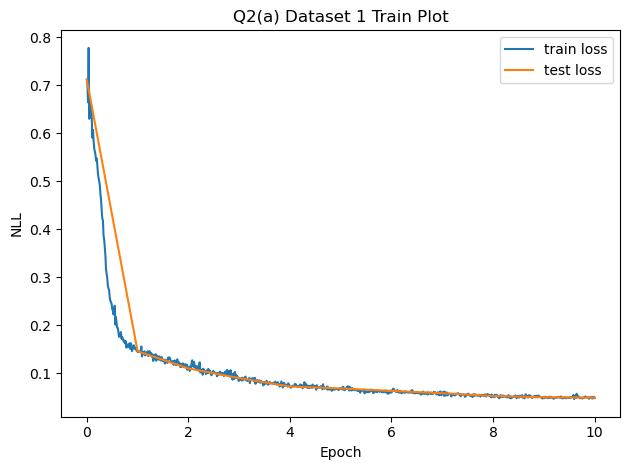

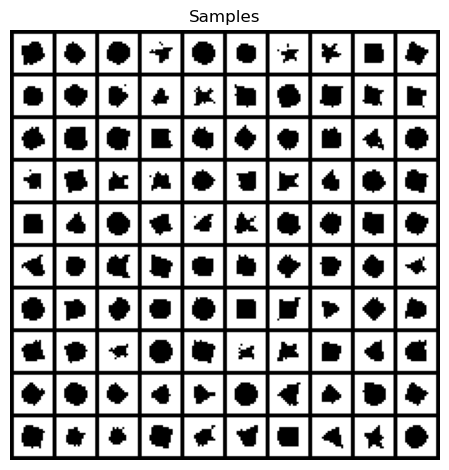

In [100]:
q2a_save_results(1, q2_a)

100%|██████████| 79/79 [00:00<00:00, 399.09it/s]


Initial test loss: 0.716


100%|██████████| 79/79 [00:00<00:00, 402.74it/s]


Epoch 1, Train Loss: 0.156, Test Loss: 0.090


100%|██████████| 79/79 [00:00<00:00, 371.62it/s]


Epoch 2, Train Loss: 0.088, Test Loss: 0.086


100%|██████████| 79/79 [00:00<00:00, 366.95it/s]


Epoch 3, Train Loss: 0.085, Test Loss: 0.083


100%|██████████| 79/79 [00:00<00:00, 361.69it/s]


Epoch 4, Train Loss: 0.083, Test Loss: 0.083


100%|██████████| 79/79 [00:00<00:00, 358.17it/s]


Epoch 5, Train Loss: 0.082, Test Loss: 0.084


100%|██████████| 79/79 [00:00<00:00, 352.29it/s]


Epoch 6, Train Loss: 0.081, Test Loss: 0.081


100%|██████████| 79/79 [00:00<00:00, 347.67it/s]


Epoch 7, Train Loss: 0.081, Test Loss: 0.080


100%|██████████| 79/79 [00:00<00:00, 346.01it/s]


Epoch 8, Train Loss: 0.080, Test Loss: 0.079


100%|██████████| 79/79 [00:00<00:00, 344.45it/s]


Epoch 9, Train Loss: 0.080, Test Loss: 0.083


100%|██████████| 79/79 [00:00<00:00, 340.71it/s]


Epoch 10, Train Loss: 0.079, Test Loss: 0.079


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]

Final Test Loss: 0.0789


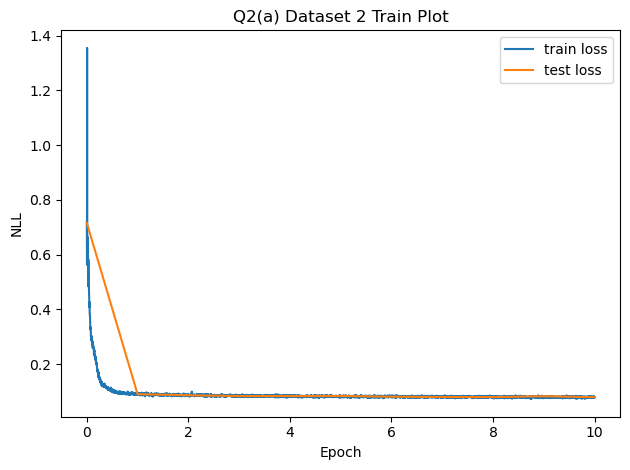

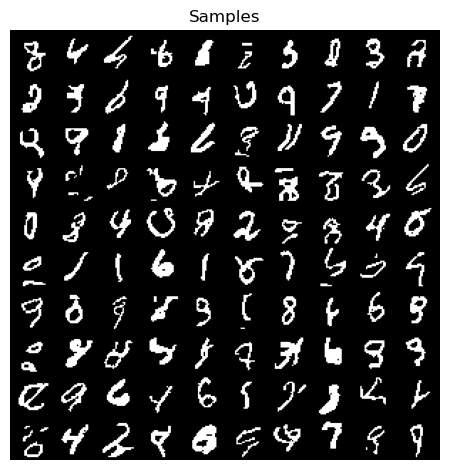

In [20]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

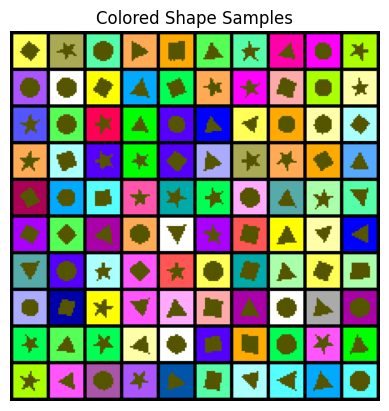

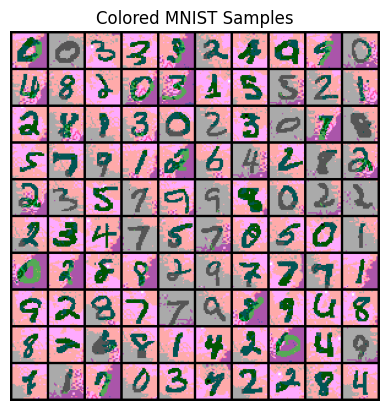

In [7]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

### Q2b train script

In [112]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 128
    lr = 1e-3
    num_epochs = 10
    H, W, C = image_shape
    K = 4 # number of possible discrete values
    max_v = 3

    model = PixelCNN(
            in_channels=C, out_channels=C*K, num_features=120,
            num_blocks=8, residual_block=True).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     samples = model.sample(H, W, C, num_samples=5)

    train_data = torch.from_numpy(train_data).to(torch.long).to(device)
    test_data = torch.from_numpy(test_data).to(torch.long).to(device)
    loss_fn = nn.CrossEntropyLoss()
    num_batches =  len(batch_indices(train_data.shape[0], batch_size))
    train_losses = np.zeros((num_epochs, num_batches))
    test_losses = np.zeros(num_epochs + 1)
    
    model.eval()
    with torch.no_grad():
        # scale to [-1, 1]
        train_data_scaled = q2_scale_input(train_data, max_v=max_v).to(device)
        test_data_scaled = q2_scale_input(test_data, max_v=max_v).to(device)

        # compute initial test loss
        test_loss, _ = q2_loop(test_data_scaled, test_data, model, batch_size, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    for epoch in range(num_epochs):
        train_loss_total, train_loss_batches = q2_loop(
                data=train_data_scaled, labels=train_data, model=model,
                batch_size=batch_size, loss_fn=loss_fn, optimizer=optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q2_loop(test_data_scaled, test_data, model, batch_size, loss_fn)
        test_losses[epoch + 1] = test_loss

        print(f'Epoch {epoch + 1}, Train Loss: {train_loss_total:.3f}, Test Loss: {test_loss:.3f}')

    # sample from model
    model.eval()
    samples = model.sample(H, W, C, num_samples=100)

    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



100%|██████████| 36/36 [00:00<00:00, 256.48it/s]


Initial test loss: 1.387


100%|██████████| 36/36 [00:00<00:00, 264.83it/s]


Epoch 1, Train Loss: 0.294, Test Loss: 0.170


100%|██████████| 36/36 [00:00<00:00, 271.41it/s]


Epoch 2, Train Loss: 0.108, Test Loss: 0.082


100%|██████████| 36/36 [00:00<00:00, 266.91it/s]


Epoch 3, Train Loss: 0.082, Test Loss: 0.071


100%|██████████| 36/36 [00:00<00:00, 269.62it/s]


Epoch 4, Train Loss: 0.070, Test Loss: 0.067


100%|██████████| 36/36 [00:00<00:00, 266.80it/s]


Epoch 5, Train Loss: 0.068, Test Loss: 0.168


100%|██████████| 36/36 [00:00<00:00, 263.69it/s]


Epoch 6, Train Loss: 0.113, Test Loss: 0.069


100%|██████████| 36/36 [00:00<00:00, 260.83it/s]


Epoch 7, Train Loss: 0.065, Test Loss: 0.062


100%|██████████| 36/36 [00:00<00:00, 266.74it/s]


Epoch 8, Train Loss: 0.059, Test Loss: 0.057


100%|██████████| 36/36 [00:00<00:00, 252.69it/s]


Epoch 9, Train Loss: 0.056, Test Loss: 0.057


100%|██████████| 36/36 [00:00<00:00, 263.51it/s]


Epoch 10, Train Loss: 0.053, Test Loss: 0.052


100%|██████████| 100/100 [01:52<00:00,  1.13s/it]

Final Test Loss: 0.0520


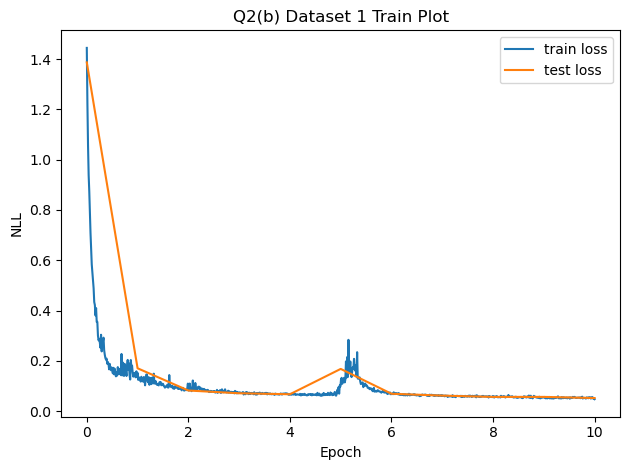

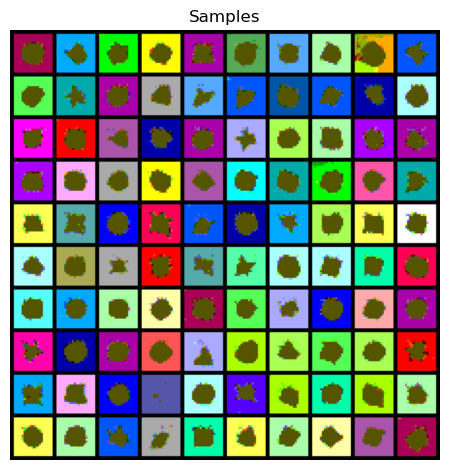

In [113]:
q2b_save_results(1, 'b', q2_b)

100%|██████████| 79/79 [00:00<00:00, 127.75it/s]


Initial test loss: 1.393


100%|██████████| 79/79 [00:00<00:00, 121.86it/s]


Epoch 1, Train Loss: 0.179, Test Loss: 0.104


100%|██████████| 79/79 [00:00<00:00, 112.86it/s]


Epoch 2, Train Loss: 0.096, Test Loss: 0.091


100%|██████████| 79/79 [00:00<00:00, 109.34it/s]


Epoch 3, Train Loss: 0.089, Test Loss: 0.088


100%|██████████| 79/79 [00:00<00:00, 106.64it/s]


Epoch 4, Train Loss: 0.086, Test Loss: 0.085


100%|██████████| 79/79 [00:00<00:00, 106.48it/s]


Epoch 5, Train Loss: 0.083, Test Loss: 0.083


100%|██████████| 79/79 [00:00<00:00, 105.71it/s]


Epoch 6, Train Loss: 0.082, Test Loss: 0.081


100%|██████████| 79/79 [00:00<00:00, 106.57it/s]


Epoch 7, Train Loss: 0.081, Test Loss: 0.083


100%|██████████| 79/79 [00:00<00:00, 106.65it/s]


Epoch 8, Train Loss: 0.124, Test Loss: 0.100


100%|██████████| 79/79 [00:00<00:00, 107.30it/s]


Epoch 9, Train Loss: 0.095, Test Loss: 0.090


100%|██████████| 79/79 [00:00<00:00, 107.01it/s]


Epoch 10, Train Loss: 0.088, Test Loss: 0.086


100%|██████████| 100/100 [03:40<00:00,  2.21s/it]

Final Test Loss: 0.0862


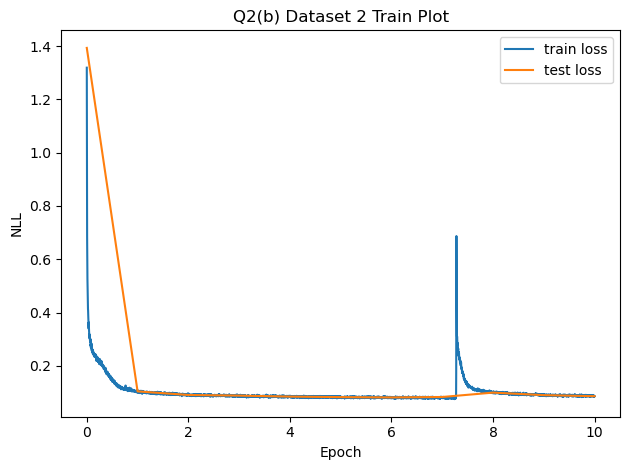

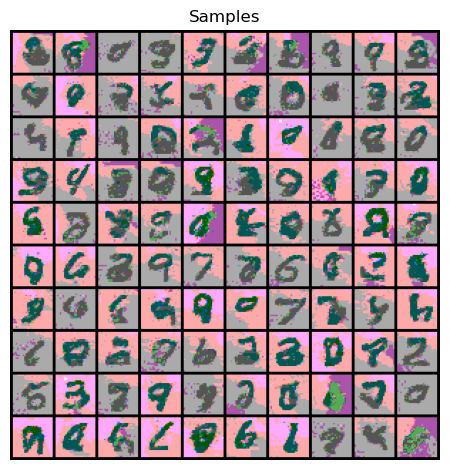

In [117]:
q2b_save_results(2, 'b', q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer).

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. We recommend to use those here as well. However, you may also use sinusoidal positional encodings if you wish (see the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper)
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



### GPT utils functions: attention, causal mask

In [17]:
"""
Q3 util functions
"""

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def attention(query, key, value, mask=None):
    """
    Implements a general attention tgt-src attention
    L: tgt length, S: src length
    In the case of self-attention, L = S
    There can be extra dimensions before the last 2 dimensions
    e.g. the head dimension in multihead-attention

    Args:
        query: (B, L, dk)
        key: (B, S, dk)
        value: (B, S, dv)
        mask: (1, L, S), True for positions allowed in attention
    """
    dk = query.shape[-1]
    # (B, L, S)
    scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(dk)
    # mask out unallowed positions by assigning negative values before softmax
    if mask is not None:
        scores = torch.masked_fill(scores, ~mask, -1e12)
    # (B, L, S), normalized for every query
    attn_prob = F.softmax(scores, dim=-1)
    # (B, L, dv)
    output = torch.matmul(attn_prob, value)
    return output


def causal_mask(n):
    """
    Generate (1, n, n) causal mask
    True for allowed positions
    where position i on the row can only attend to
    positions j <= i
    """
    mask = torch.tril(torch.ones((n, n))).type(torch.bool)
    return mask.unsqueeze(0)


def copy_module(module, N):
    """
    Return a list of N identical module
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### Q3 Image tokenization

In [16]:
def pixel_to_token(pixels, C, K):
    """
    Vectorized conversion of pixels to tokens using PyTorch.
    Each unique vector of channel value [r, g, b] 
    where {r, g, b} \in [0, ..., K-1] is converted to a single token
    There are K^C possible discrete token values
    
    Args:
        pixels: A tensor of pixels with shape (B*H*W, C).
        K: The number of possible discrete values for each pixel channel.
        C: The number of channels.
    Returns:
        tokens: torch.tensor, (B*H*W, 1), w/ possible values in [0, K^C - 1]
    """
    # Create a multiplier for each channel's contribution to the token.
    # This will be [K^(C-1), K^(C-2), ..., K^0] for C channels.
    multipliers = K ** torch.arange(C - 1, -1, -1, device=pixels.device, dtype=pixels.dtype)
    
    # Multiply each pixel by its channel multiplier and sum to get the token.
    tokens = torch.sum(pixels * multipliers, dim=1)
    return tokens


def token_to_pixel(tokens, C, K):
    """
    Vectorized mapping of tokens back to their original RGB (or single channel) values.
    
    Args:
        tokens: torch.tensor, shape (B*H*W,), tokens representing the pixels.
        C: Integer, number of color channels.
        K: Integer, number of possible discrete values for each pixel/channel.
        
    Returns:
        pixels: torch.tensor, shape (B*H*W, C), the original pixel values.
    """    
    # Prepare the divisor for each channel based on its position
    divisors = K ** torch.arange(C-1, -1, -1, device=tokens.device, dtype=tokens.dtype)
    # Compute pixel values for each channel
    pixels = tokens.unsqueeze(1) // divisors % K
    return pixels


def tokenize_images(data, K):
    """
    Tokenize an array of images (vectorized)

    Args:
        data: (B, H, W, C)
        K: possible discrete values
    """
    # flatten the spatial dimensions and keep the color channel last
    B, H, W, C = data.shape
    flattened_images = data.reshape(-1, C) # (B * H * W, C)

    tokens = pixel_to_token(flattened_images, C, K)

    # reshape back to the original batch of images
    # with spatial dimensions flattened
    tokens = tokens.view(B, H * W)

    # add special token K**C to represent <bos>
    # to the beginning of each image
    bos_token = torch.full((B, 1), K**C, dtype=torch.long, device=data.device)
    tokens = torch.cat([bos_token, tokens], dim=1)  # (B, H * W + 1)
    return tokens

### GPT components

In [8]:
"""
Q3 module definitions
"""
class Embedding(nn.Module):
    """
    Implements learned embeddings to convert tokens to
    vectors of dimension d_model
    """
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.embed(x)
        # return self.embed(x) * math.sqrt(self.d_model)


class LearnedPositionalEncoding(nn.Module):
    """
    Implements learned positional encoding
    Forward pass adds the positional encoding to input
    """
    def __init__(self, d_model, max_len):
        super().__init__()
        self.pos_encode = nn.Embedding(max_len, d_model)

    def forward(self, x):
        seq_len = x.size(1)
        positions = torch.arange(seq_len, dtype=torch.long, device=x.device)
        # (L, d_model)
        pe = self.pos_encode(positions)
        # (B, L, d_model)
        out = x + pe.unsqueeze(0)
        return out


class MultiheadAttention(nn.Module):
    """
    Implements multihead attention
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        if d_model % num_heads != 0:
            raise ValueError('d_model needs to be divisible by num_heads')
        self.dk = d_model // num_heads
        self.num_heads = num_heads
        # linear projects on query, key, value and output
        self.projections = copy_module(nn.Linear(d_model, d_model), 4)

    def forward(self, query, key, value, mask=None):
        """
        Args:
            query, key, value: (B, L, dmodel), (B, L, dmodel), (B, L, dmodel)
            for self attention, these are the current step
            model embedding, i.e. x
        """
        B = query.shape[0]

        # project query, key and value separetely
        # reshape to (B, h, L, dk)
        query, key, value = [
            proj(x).view(B, -1, self.num_heads, self.dk).transpose(1, 2)
            for x, proj in zip([query, key, value], self.projections)
        ]

        # apply attention to all heads in one go
        # mask is applied to each head
        if mask is not None:
            mask = mask.unsqueeze(1)
        # (B, h, L, dk)
        x = attention(query, key, value, mask=mask)

        # concat output of each head by view and project
        x = x.transpose(1, 2).contiguous().view(B, -1, self.num_heads * self.dk)
        x = self.projections[-1](x)
        return x

    
class CachedMultiheadAttention(MultiheadAttention):
    """
    Implements multihead attention
    """
    def __init__(self, d_model, num_heads):
        super().__init__(d_model, num_heads)

    def forward(self, query, key, value, mask=None, cache=None):
        B = query.shape[0]
        
        if cache is None:
            # if cache is empty
            # compute Q, K, V for the entire length
            cache = {'K': None, 'V': None}
            # project query, key and value separetely
            # reshape to (B, h, L, dk)
            query, key, value = [
                proj(x).view(B, -1, self.num_heads, self.dk).transpose(1, 2)
                for x, proj in zip([query, key, value], self.projections)
            ]
        else:
            # if cache is not emtpy
            # that means we are in the middle of inference
            # only compute Q, K, V
            # for the last (i.e. latest) position
            query, key, value = [
                proj(x[:, -1, :]).view(B, -1, self.num_heads, self.dk).transpose(1, 2)
                for x, proj in zip([query, key, value], self.projections)
            ]

        # prepend cached K and V if available
        # (B, h, Lc + L, dk)
        # Lc is the length of the cached K and V
        if cache['K'] is not None:
            key = torch.cat([cache['K'], key], dim=2)
        if cache['V'] is not None:
            value = torch.cat([cache['V'], value], dim=2)
            
        # update cache
        cache['K'], cache['V'] = key, value
        
        # apply attention to all heads in one go
        # mask is applied to each head
        if mask is not None:
            # (1, 1, L, L)
            mask = mask.unsqueeze(1)
        # (B, h, L, dk)
        x = attention(query, key, value, mask=mask)
        
        # concat output of each head by view and project
        x = x.transpose(1, 2).contiguous().view(B, -1, self.num_heads * self.dk)
        x = self.projections[-1](x)
        return x, cache


class PositionwiseFeedForward(nn.Module):
    """
    2 layers of Position-wise feedforward with GELU activation
    """
    def __init__(self, d_model):
        super().__init__()
        d_linear = d_model * 4
        self.linear1 = nn.Linear(d_model, d_linear)
        self.linear2 = nn.Linear(d_linear, d_model)

    def forward(self, x):
        return self.linear2(F.gelu(self.linear1(x)))


class GPTLayer(nn.Module):
    """
    Implement 1 layer of GPT
    equivalent to one decoder layer in Transformer
    w/o the encoder cross attention
    """
    def __init__(self, d_model, num_heads, use_cache=True, dropout=0.0):
        super().__init__()
        self.use_cache = use_cache
        if use_cache:
            self.attn = CachedMultiheadAttention(d_model, num_heads)
        else:
            self.attn = MultiheadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(p=dropout)
        self.dropout2 = nn.Dropout(p=dropout)

    def forward(self, x, mask, attn_cache=None):
        identity = x
        if self.use_cache:
            # use cached K, V for attention
            attn_out, attn_cache = self.attn(x, x, x, mask=mask, cache=attn_cache)
        else:
            # use vanilla attention
            attn_out = self.attn(x, x, x, mask=mask)
            attn_cache = None
        out = self.dropout1(attn_out)
        out = attn_out + identity
        out = self.layer_norm1(out)

        identity = out
        out = self.ffn(out)
        out = self.dropout2(out)
        out += identity
        out = self.layer_norm2(out)

        return out, attn_cache

### GPT class definition & inference

In [9]:
class GPT(nn.Module):
    """
    Implements autogressive transformer
    """
    def __init__(
            self, d_model, num_layers, vocab_size, num_heads, max_len, 
            use_cache=True, dropout=0.0):
        super().__init__()
        self.embed = Embedding(d_model, vocab_size + 1)
        self.pos_encode = LearnedPositionalEncoding(d_model, max_len)
        self.layers = copy_module(GPTLayer(d_model, num_heads, use_cache, dropout), num_layers)
        self.output_linear = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, cache=None):
        """
        Args:
            x: (B, L) with tokens as values
                Image height and width should be flattened
            mask: (1, L, L)

        Returns:
            out: (B, vocab_size, L) of logits
        """
        # create causal mask
        mask = causal_mask(x.shape[-1]).to(x.device)

        # embed input tokens
        out = self.embed(x) # (B, L, d_model)

        # add positional encoding
        out = self.pos_encode(out)
        
        out = self.dropout(out)

        # initialize cache if inference
        # each layer maintains its own cache
        if cache is None:
            cache = [None] * len(self.layers) 
        
        # GPT layers
        # each layer is cache is updated
        new_cache = []
        for i, layer in enumerate(self.layers):            
            # update cache if using
            out, layer_cache = layer(out, mask, attn_cache=cache[i])
            new_cache.append(layer_cache)
                
        # covert embedding to output tokens
        out = self.output_linear(out)
        return out.transpose(1, 2), new_cache

    def sample(self, image_shape, K, num_samples=100, return_time=False):
        B = num_samples
        H, W, C = image_shape
        # time for each sampling step over the length of the sequence
        sampling_times = np.zeros(H*W)

        # generate samples in batch
        with torch.no_grad():
            start_time = time.time()
            # start with <bos> token (vocab_size)
            bos = K**C
            x = torch.full((B, 1), bos, device=device)
            cache = None
            # iterate over each pixel
            for pixel_index in range(H * W):
                start_time = time.time()
                logits, cache = self.forward(x, cache=cache) # x: (B, curr_len)
                # use logits = (B, vocab_size) to sample a single token
                probs = F.softmax(logits[:, :, -1], dim=-1) # (B, vocab_size)
                next_token = torch.multinomial(probs, 1) # (B, 1)
                x = torch.cat((x, next_token), dim=-1) # (B, curr_len + 1)
                sampling_times[pixel_index] = time.time() - start_time

            # covert token back to pixel value to store in sample tensor
            # x: (B*H*W,), ignoring bos
            x = x[:, 1:].flatten() # (B*H*W,)
            samples = token_to_pixel(x, C, K).view(B, H, W, C)
                    
        samples = samples.detach().cpu().numpy()

        if return_time:
            return samples, sampling_times
        else:
            return samples

### Q3 training script

In [10]:
def q3_loop(
        data, model, batch_size, loss_fn, optimizer=None):
    """
    Training or evaluation loop over all batches
    """
    if optimizer:
        model.train()
    else:
        model.eval()

    batches = batch_indices(data.shape[0], batch_size)
    loss_total = 0
    num_batches = len(batches)
    loss_batches = np.zeros(num_batches)
    
    for i, batch_idx in enumerate(tqdm(batches)):
        if optimizer:
            optimizer.zero_grad()

        batch = data[batch_idx]
        logits, _ = model(batch)
        logits = logits[:, :, :-1]
        # shift target by one so the model is predicting the next token
        labels = batch[:, 1:]
        loss = loss_fn(logits, labels)
        loss_total += loss.item() * batch_idx.shape[0]
        loss_batches[i] = loss.item()

        if optimizer:
            loss.backward()
            optimizer.step()

    loss_total /= data.shape[0]
    return loss_total, loss_batches


def lr_lambda(current_step, warmup_steps, total_steps):
    if current_step < warmup_steps:
        return current_step / warmup_steps
    else:
        # cosine decay
        progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
        return 0.5 * (1.0 + math.cos(math.pi * progress))

In [82]:
def q3_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1}
    image_shape: (H, W, 1), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                     used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    batch_size = 64
    lr = 1e-3
    num_epochs = 50
    d_model = 128
    num_heads = 4
    num_layers = 2
    warmup_steps = 100
    num_batches = len(batch_indices(train_data.shape[0], batch_size))
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')

    H, W, C = image_shape
    K = 2 # number of possible discrete values
    vocab_size = K**C
    max_len = H * W + 1

    model = GPT(
            d_model=d_model, num_layers=num_layers, vocab_size=vocab_size,
            num_heads=num_heads, max_len=max_len).to(device)
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        # tokenize data
        train_data = tokenize_images(
            torch.from_numpy(train_data).to(torch.long).to(device), K)
        test_data = tokenize_images(
            torch.from_numpy(test_data).to(torch.long).to(device), K)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q3_loop(test_data, model, batch_size, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')
        
    # define optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, 
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q3_loop(train_data, model, batch_size, loss_fn, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q3_loop(test_data, model, batch_size, loss_fn)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    samples = model.sample(image_shape, K, num_samples=100)

    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

Total number of training steps: 8200


100%|██████████| 71/71 [00:00<00:00, 155.88it/s]


Initial test loss: 0.882


100%|██████████| 71/71 [00:00<00:00, 153.56it/s]


Epoch 1, Train Loss: 0.881, Test Loss: 0.882


100%|██████████| 71/71 [00:00<00:00, 153.12it/s]


Epoch 2, Train Loss: 0.481, Test Loss: 0.278


100%|██████████| 71/71 [00:00<00:00, 153.29it/s]


Epoch 3, Train Loss: 0.223, Test Loss: 0.211


100%|██████████| 71/71 [00:00<00:00, 152.82it/s]


Epoch 4, Train Loss: 0.207, Test Loss: 0.202


100%|██████████| 71/71 [00:00<00:00, 152.54it/s]


Epoch 5, Train Loss: 0.196, Test Loss: 0.189


100%|██████████| 71/71 [00:00<00:00, 152.39it/s]


Epoch 6, Train Loss: 0.176, Test Loss: 0.160


100%|██████████| 71/71 [00:00<00:00, 152.07it/s]


Epoch 7, Train Loss: 0.141, Test Loss: 0.123


100%|██████████| 71/71 [00:00<00:00, 151.45it/s]


Epoch 8, Train Loss: 0.113, Test Loss: 0.105


100%|██████████| 71/71 [00:00<00:00, 151.52it/s]


Epoch 9, Train Loss: 0.101, Test Loss: 0.096


100%|██████████| 71/71 [00:00<00:00, 151.40it/s]


Epoch 10, Train Loss: 0.094, Test Loss: 0.092


100%|██████████| 71/71 [00:00<00:00, 151.08it/s]


Epoch 11, Train Loss: 0.089, Test Loss: 0.085


100%|██████████| 71/71 [00:00<00:00, 150.84it/s]


Epoch 12, Train Loss: 0.084, Test Loss: 0.081


100%|██████████| 71/71 [00:00<00:00, 150.68it/s]


Epoch 13, Train Loss: 0.080, Test Loss: 0.077


100%|██████████| 71/71 [00:00<00:00, 150.33it/s]


Epoch 14, Train Loss: 0.076, Test Loss: 0.075


100%|██████████| 71/71 [00:00<00:00, 150.23it/s]


Epoch 15, Train Loss: 0.073, Test Loss: 0.075


100%|██████████| 71/71 [00:00<00:00, 149.84it/s]


Epoch 16, Train Loss: 0.070, Test Loss: 0.069


100%|██████████| 71/71 [00:00<00:00, 149.32it/s]


Epoch 17, Train Loss: 0.068, Test Loss: 0.067


100%|██████████| 71/71 [00:00<00:00, 148.84it/s]


Epoch 18, Train Loss: 0.065, Test Loss: 0.063


100%|██████████| 71/71 [00:00<00:00, 148.79it/s]


Epoch 19, Train Loss: 0.063, Test Loss: 0.061


100%|██████████| 71/71 [00:00<00:00, 146.71it/s]


Epoch 20, Train Loss: 0.061, Test Loss: 0.060


100%|██████████| 71/71 [00:00<00:00, 146.71it/s]


Epoch 21, Train Loss: 0.059, Test Loss: 0.058


100%|██████████| 71/71 [00:00<00:00, 146.52it/s]


Epoch 22, Train Loss: 0.058, Test Loss: 0.057


100%|██████████| 71/71 [00:00<00:00, 146.51it/s]


Epoch 23, Train Loss: 0.055, Test Loss: 0.054


100%|██████████| 71/71 [00:00<00:00, 148.79it/s]


Epoch 24, Train Loss: 0.054, Test Loss: 0.053


100%|██████████| 71/71 [00:00<00:00, 148.44it/s]


Epoch 25, Train Loss: 0.053, Test Loss: 0.052


100%|██████████| 71/71 [00:00<00:00, 148.53it/s]


Epoch 26, Train Loss: 0.051, Test Loss: 0.052


100%|██████████| 71/71 [00:00<00:00, 149.11it/s]


Epoch 27, Train Loss: 0.050, Test Loss: 0.049


100%|██████████| 71/71 [00:00<00:00, 149.16it/s]


Epoch 28, Train Loss: 0.049, Test Loss: 0.049


100%|██████████| 71/71 [00:00<00:00, 149.54it/s]


Epoch 29, Train Loss: 0.048, Test Loss: 0.049


100%|██████████| 71/71 [00:00<00:00, 149.47it/s]


Epoch 30, Train Loss: 0.047, Test Loss: 0.047


100%|██████████| 71/71 [00:00<00:00, 149.69it/s]


Epoch 31, Train Loss: 0.046, Test Loss: 0.046


100%|██████████| 71/71 [00:00<00:00, 142.72it/s]


Epoch 32, Train Loss: 0.046, Test Loss: 0.046


100%|██████████| 71/71 [00:00<00:00, 143.53it/s]


Epoch 33, Train Loss: 0.045, Test Loss: 0.046


100%|██████████| 71/71 [00:00<00:00, 144.74it/s]


Epoch 34, Train Loss: 0.045, Test Loss: 0.046


100%|██████████| 71/71 [00:00<00:00, 145.05it/s]


Epoch 35, Train Loss: 0.044, Test Loss: 0.044


100%|██████████| 71/71 [00:00<00:00, 145.45it/s]


Epoch 36, Train Loss: 0.043, Test Loss: 0.044


100%|██████████| 71/71 [00:00<00:00, 146.14it/s]


Epoch 37, Train Loss: 0.043, Test Loss: 0.043


100%|██████████| 71/71 [00:00<00:00, 149.45it/s]


Epoch 38, Train Loss: 0.043, Test Loss: 0.042


100%|██████████| 71/71 [00:00<00:00, 151.00it/s]


Epoch 39, Train Loss: 0.042, Test Loss: 0.043


100%|██████████| 71/71 [00:00<00:00, 151.23it/s]


Epoch 40, Train Loss: 0.041, Test Loss: 0.042


100%|██████████| 71/71 [00:00<00:00, 151.50it/s]


Epoch 41, Train Loss: 0.041, Test Loss: 0.041


100%|██████████| 71/71 [00:00<00:00, 151.57it/s]


Epoch 42, Train Loss: 0.041, Test Loss: 0.041


100%|██████████| 71/71 [00:00<00:00, 151.25it/s]


Epoch 43, Train Loss: 0.040, Test Loss: 0.041


100%|██████████| 71/71 [00:00<00:00, 151.75it/s]


Epoch 44, Train Loss: 0.040, Test Loss: 0.041


100%|██████████| 71/71 [00:00<00:00, 152.04it/s]


Epoch 45, Train Loss: 0.040, Test Loss: 0.041


100%|██████████| 71/71 [00:00<00:00, 151.73it/s]


Epoch 46, Train Loss: 0.039, Test Loss: 0.040


100%|██████████| 71/71 [00:00<00:00, 151.66it/s]


Epoch 47, Train Loss: 0.039, Test Loss: 0.040


100%|██████████| 71/71 [00:00<00:00, 152.52it/s]


Epoch 48, Train Loss: 0.039, Test Loss: 0.039


100%|██████████| 71/71 [00:00<00:00, 152.08it/s]


Epoch 49, Train Loss: 0.038, Test Loss: 0.040


100%|██████████| 71/71 [00:00<00:00, 151.77it/s]


Epoch 50, Train Loss: 0.038, Test Loss: 0.039
Final Test Loss: 0.0392


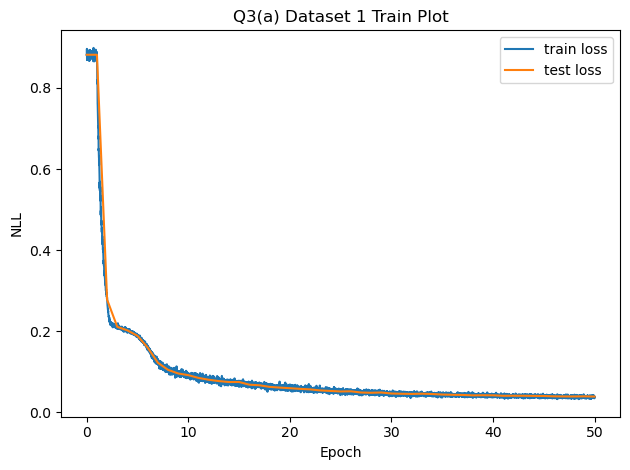

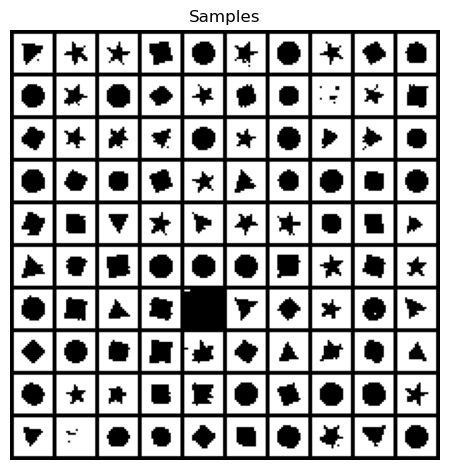

In [204]:
q3ab_save_results(1, 'a', q3_a)

Total number of training steps: 46900


100%|██████████| 157/157 [00:03<00:00, 49.17it/s]


Initial test loss: 0.824


100%|██████████| 157/157 [00:03<00:00, 47.99it/s]


Epoch 1, Train Loss: 0.825, Test Loss: 0.824


100%|██████████| 157/157 [00:03<00:00, 45.25it/s]


Epoch 2, Train Loss: 0.253, Test Loss: 0.219


100%|██████████| 157/157 [00:03<00:00, 48.34it/s]


Epoch 3, Train Loss: 0.214, Test Loss: 0.208


100%|██████████| 157/157 [00:03<00:00, 48.37it/s]


Epoch 4, Train Loss: 0.200, Test Loss: 0.189


100%|██████████| 157/157 [00:03<00:00, 48.27it/s]


Epoch 5, Train Loss: 0.180, Test Loss: 0.174


100%|██████████| 157/157 [00:03<00:00, 48.15it/s]


Epoch 6, Train Loss: 0.172, Test Loss: 0.168


100%|██████████| 157/157 [00:03<00:00, 48.16it/s]


Epoch 7, Train Loss: 0.165, Test Loss: 0.160


100%|██████████| 157/157 [00:03<00:00, 48.21it/s]


Epoch 8, Train Loss: 0.155, Test Loss: 0.149


100%|██████████| 157/157 [00:03<00:00, 48.27it/s]


Epoch 9, Train Loss: 0.145, Test Loss: 0.138


100%|██████████| 157/157 [00:03<00:00, 48.29it/s]


Epoch 10, Train Loss: 0.136, Test Loss: 0.131


100%|██████████| 157/157 [00:03<00:00, 48.21it/s]


Epoch 11, Train Loss: 0.128, Test Loss: 0.123


100%|██████████| 157/157 [00:03<00:00, 48.16it/s]


Epoch 12, Train Loss: 0.121, Test Loss: 0.117


100%|██████████| 157/157 [00:03<00:00, 48.18it/s]


Epoch 13, Train Loss: 0.116, Test Loss: 0.112


100%|██████████| 157/157 [00:03<00:00, 48.15it/s]


Epoch 14, Train Loss: 0.112, Test Loss: 0.109


100%|██████████| 157/157 [00:03<00:00, 48.18it/s]


Epoch 15, Train Loss: 0.108, Test Loss: 0.106


100%|██████████| 157/157 [00:03<00:00, 48.22it/s]


Epoch 16, Train Loss: 0.106, Test Loss: 0.103


100%|██████████| 157/157 [00:03<00:00, 48.16it/s]


Epoch 17, Train Loss: 0.104, Test Loss: 0.101


100%|██████████| 157/157 [00:03<00:00, 48.12it/s]


Epoch 18, Train Loss: 0.102, Test Loss: 0.101


100%|██████████| 157/157 [00:03<00:00, 48.23it/s]


Epoch 19, Train Loss: 0.100, Test Loss: 0.099


100%|██████████| 157/157 [00:03<00:00, 48.20it/s]


Epoch 20, Train Loss: 0.099, Test Loss: 0.098


100%|██████████| 157/157 [00:03<00:00, 48.24it/s]


Epoch 21, Train Loss: 0.097, Test Loss: 0.096


100%|██████████| 157/157 [00:03<00:00, 48.17it/s]


Epoch 22, Train Loss: 0.096, Test Loss: 0.095


100%|██████████| 157/157 [00:03<00:00, 48.20it/s]


Epoch 23, Train Loss: 0.095, Test Loss: 0.094


100%|██████████| 157/157 [00:03<00:00, 48.16it/s]


Epoch 24, Train Loss: 0.094, Test Loss: 0.093


100%|██████████| 157/157 [00:03<00:00, 48.17it/s]


Epoch 25, Train Loss: 0.093, Test Loss: 0.092


100%|██████████| 157/157 [00:03<00:00, 48.15it/s]


Epoch 26, Train Loss: 0.092, Test Loss: 0.091


100%|██████████| 157/157 [00:03<00:00, 48.18it/s]


Epoch 27, Train Loss: 0.091, Test Loss: 0.090


100%|██████████| 157/157 [00:03<00:00, 48.18it/s]


Epoch 28, Train Loss: 0.090, Test Loss: 0.090


100%|██████████| 157/157 [00:03<00:00, 48.22it/s]


Epoch 29, Train Loss: 0.089, Test Loss: 0.089


100%|██████████| 157/157 [00:03<00:00, 48.19it/s]


Epoch 30, Train Loss: 0.089, Test Loss: 0.088


100%|██████████| 157/157 [00:03<00:00, 48.23it/s]


Epoch 31, Train Loss: 0.088, Test Loss: 0.088


100%|██████████| 157/157 [00:03<00:00, 48.20it/s]


Epoch 32, Train Loss: 0.087, Test Loss: 0.087


100%|██████████| 157/157 [00:03<00:00, 48.17it/s]


Epoch 33, Train Loss: 0.087, Test Loss: 0.087


100%|██████████| 157/157 [00:03<00:00, 48.19it/s]


Epoch 34, Train Loss: 0.086, Test Loss: 0.086


100%|██████████| 157/157 [00:03<00:00, 48.23it/s]


Epoch 35, Train Loss: 0.086, Test Loss: 0.086


100%|██████████| 157/157 [00:03<00:00, 48.17it/s]


Epoch 36, Train Loss: 0.085, Test Loss: 0.085


100%|██████████| 157/157 [00:03<00:00, 48.20it/s]


Epoch 37, Train Loss: 0.085, Test Loss: 0.085


100%|██████████| 157/157 [00:03<00:00, 48.16it/s]


Epoch 38, Train Loss: 0.084, Test Loss: 0.084


100%|██████████| 157/157 [00:03<00:00, 48.20it/s]


Epoch 39, Train Loss: 0.084, Test Loss: 0.084


100%|██████████| 157/157 [00:03<00:00, 48.18it/s]


Epoch 40, Train Loss: 0.083, Test Loss: 0.084


100%|██████████| 157/157 [00:03<00:00, 48.13it/s]


Epoch 41, Train Loss: 0.083, Test Loss: 0.084


100%|██████████| 157/157 [00:03<00:00, 48.15it/s]


Epoch 42, Train Loss: 0.083, Test Loss: 0.084


100%|██████████| 157/157 [00:03<00:00, 47.86it/s]


Epoch 43, Train Loss: 0.082, Test Loss: 0.083


100%|██████████| 157/157 [00:03<00:00, 48.14it/s]


Epoch 44, Train Loss: 0.082, Test Loss: 0.082


100%|██████████| 157/157 [00:03<00:00, 48.21it/s]


Epoch 45, Train Loss: 0.082, Test Loss: 0.083


100%|██████████| 157/157 [00:03<00:00, 48.17it/s]


Epoch 46, Train Loss: 0.081, Test Loss: 0.082


100%|██████████| 157/157 [00:03<00:00, 48.15it/s]


Epoch 47, Train Loss: 0.081, Test Loss: 0.082


100%|██████████| 157/157 [00:03<00:00, 48.18it/s]


Epoch 48, Train Loss: 0.081, Test Loss: 0.082


100%|██████████| 157/157 [00:03<00:00, 48.18it/s]


Epoch 49, Train Loss: 0.080, Test Loss: 0.081


100%|██████████| 157/157 [00:03<00:00, 48.23it/s]


Epoch 50, Train Loss: 0.080, Test Loss: 0.081
Final Test Loss: 0.0812


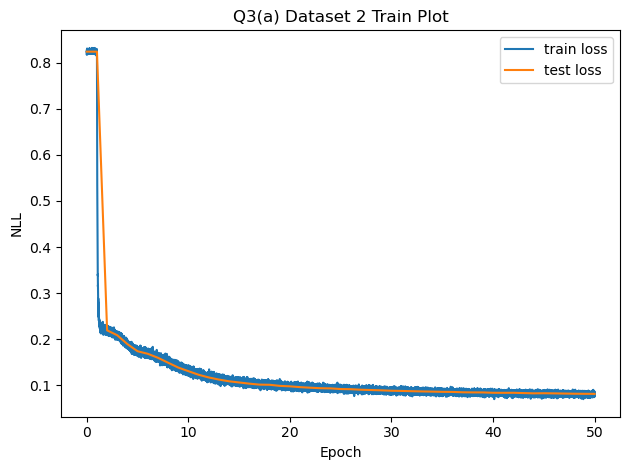

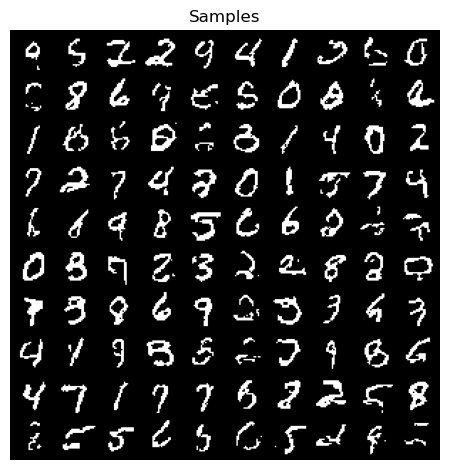

In [83]:
q3ab_save_results(2, 'a', q3_a)

## Part (b) iGPT on Colored Shapes and MNIST

Now, implement an iGPT that models color. In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf)

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


### Q3(b) train script

In [78]:
def q3_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    if dset_id == 1:
        batch_size = 64
        lr = 1e-3
        num_epochs = 50
        d_model = 128
        num_heads = 4
        num_layers = 2
        warmup_steps = 100
    else:
        batch_size = 64
        lr = 1e-3
        num_epochs = 50
        d_model = 128
        num_heads = 4
        num_layers = 2
        warmup_steps = 100


    num_batches = len(batch_indices(train_data.shape[0], batch_size))
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')

    H, W, C = image_shape
    K = 4 # number of possible discrete values
    vocab_size = K**C
    max_len = H * W + 1

    model = GPT(
        d_model=d_model, num_layers=num_layers, vocab_size=vocab_size,
        num_heads=num_heads, max_len=max_len, use_cache=False).to(device)
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        # tokenize data
        train_data = tokenize_images(
            torch.from_numpy(train_data).to(torch.long).to(device), K)
        test_data = tokenize_images(
            torch.from_numpy(test_data).to(torch.long).to(device), K)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q3_loop(test_data, model, batch_size, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')
        
    # define optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, 
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q3_loop(train_data, model, batch_size, loss_fn, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q3_loop(test_data, model, batch_size, loss_fn)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    samples = model.sample(image_shape, K, num_samples=100)
    
    torch.save(model.state_dict(), f'q3_b_dset{dset_id}_model_no_cache.pt')

    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

Total number of training steps: 8200


100%|██████████| 71/71 [00:00<00:00, 153.73it/s]


Initial test loss: 4.302


100%|██████████| 71/71 [00:00<00:00, 152.42it/s]


Epoch 1, Train Loss: 4.308, Test Loss: 4.302


100%|██████████| 71/71 [00:00<00:00, 151.88it/s]


Epoch 2, Train Loss: 4.228, Test Loss: 4.141


100%|██████████| 71/71 [00:00<00:00, 151.63it/s]


Epoch 3, Train Loss: 3.989, Test Loss: 3.822


100%|██████████| 71/71 [00:00<00:00, 151.24it/s]


Epoch 4, Train Loss: 3.598, Test Loss: 3.367


100%|██████████| 71/71 [00:00<00:00, 151.14it/s]


Epoch 5, Train Loss: 3.126, Test Loss: 2.902


100%|██████████| 71/71 [00:00<00:00, 150.95it/s]


Epoch 6, Train Loss: 2.680, Test Loss: 2.464


100%|██████████| 71/71 [00:00<00:00, 150.93it/s]


Epoch 7, Train Loss: 2.230, Test Loss: 2.007


100%|██████████| 71/71 [00:00<00:00, 150.77it/s]


Epoch 8, Train Loss: 1.772, Test Loss: 1.562


100%|██████████| 71/71 [00:00<00:00, 151.03it/s]


Epoch 9, Train Loss: 1.357, Test Loss: 1.184


100%|██████████| 71/71 [00:00<00:00, 150.20it/s]


Epoch 10, Train Loss: 1.028, Test Loss: 0.900


100%|██████████| 71/71 [00:00<00:00, 149.64it/s]


Epoch 11, Train Loss: 0.792, Test Loss: 0.704


100%|██████████| 71/71 [00:00<00:00, 149.24it/s]


Epoch 12, Train Loss: 0.632, Test Loss: 0.572


100%|██████████| 71/71 [00:00<00:00, 148.92it/s]


Epoch 13, Train Loss: 0.522, Test Loss: 0.479


100%|██████████| 71/71 [00:00<00:00, 148.74it/s]


Epoch 14, Train Loss: 0.443, Test Loss: 0.412


100%|██████████| 71/71 [00:00<00:00, 148.75it/s]


Epoch 15, Train Loss: 0.385, Test Loss: 0.361


100%|██████████| 71/71 [00:00<00:00, 148.63it/s]


Epoch 16, Train Loss: 0.339, Test Loss: 0.318


100%|██████████| 71/71 [00:00<00:00, 148.17it/s]


Epoch 17, Train Loss: 0.298, Test Loss: 0.280


100%|██████████| 71/71 [00:00<00:00, 148.13it/s]


Epoch 18, Train Loss: 0.263, Test Loss: 0.247


100%|██████████| 71/71 [00:00<00:00, 148.03it/s]


Epoch 19, Train Loss: 0.233, Test Loss: 0.219


100%|██████████| 71/71 [00:00<00:00, 148.06it/s]


Epoch 20, Train Loss: 0.209, Test Loss: 0.199


100%|██████████| 71/71 [00:00<00:00, 147.75it/s]


Epoch 21, Train Loss: 0.191, Test Loss: 0.182


100%|██████████| 71/71 [00:00<00:00, 147.54it/s]


Epoch 22, Train Loss: 0.176, Test Loss: 0.169


100%|██████████| 71/71 [00:00<00:00, 147.61it/s]


Epoch 23, Train Loss: 0.163, Test Loss: 0.158


100%|██████████| 71/71 [00:00<00:00, 147.67it/s]


Epoch 24, Train Loss: 0.153, Test Loss: 0.149


100%|██████████| 71/71 [00:00<00:00, 147.35it/s]


Epoch 25, Train Loss: 0.145, Test Loss: 0.141


100%|██████████| 71/71 [00:00<00:00, 147.12it/s]


Epoch 26, Train Loss: 0.138, Test Loss: 0.135


100%|██████████| 71/71 [00:00<00:00, 146.95it/s]


Epoch 27, Train Loss: 0.132, Test Loss: 0.129


100%|██████████| 71/71 [00:00<00:00, 147.14it/s]


Epoch 28, Train Loss: 0.126, Test Loss: 0.124


100%|██████████| 71/71 [00:00<00:00, 146.36it/s]


Epoch 29, Train Loss: 0.122, Test Loss: 0.120


100%|██████████| 71/71 [00:00<00:00, 146.83it/s]


Epoch 30, Train Loss: 0.118, Test Loss: 0.116


100%|██████████| 71/71 [00:00<00:00, 146.18it/s]


Epoch 31, Train Loss: 0.115, Test Loss: 0.113


100%|██████████| 71/71 [00:00<00:00, 146.23it/s]


Epoch 32, Train Loss: 0.112, Test Loss: 0.110


100%|██████████| 71/71 [00:00<00:00, 145.87it/s]


Epoch 33, Train Loss: 0.109, Test Loss: 0.108


100%|██████████| 71/71 [00:00<00:00, 146.42it/s]


Epoch 34, Train Loss: 0.107, Test Loss: 0.106


100%|██████████| 71/71 [00:00<00:00, 146.54it/s]


Epoch 35, Train Loss: 0.105, Test Loss: 0.104


100%|██████████| 71/71 [00:00<00:00, 145.34it/s]


Epoch 36, Train Loss: 0.103, Test Loss: 0.102


100%|██████████| 71/71 [00:00<00:00, 145.58it/s]


Epoch 37, Train Loss: 0.101, Test Loss: 0.100


100%|██████████| 71/71 [00:00<00:00, 145.97it/s]


Epoch 38, Train Loss: 0.100, Test Loss: 0.099


100%|██████████| 71/71 [00:00<00:00, 146.22it/s]


Epoch 39, Train Loss: 0.098, Test Loss: 0.098


100%|██████████| 71/71 [00:00<00:00, 145.94it/s]


Epoch 40, Train Loss: 0.097, Test Loss: 0.096


100%|██████████| 71/71 [00:00<00:00, 146.16it/s]


Epoch 41, Train Loss: 0.096, Test Loss: 0.095


100%|██████████| 71/71 [00:00<00:00, 146.65it/s]


Epoch 42, Train Loss: 0.094, Test Loss: 0.094


100%|██████████| 71/71 [00:00<00:00, 146.83it/s]


Epoch 43, Train Loss: 0.093, Test Loss: 0.093


100%|██████████| 71/71 [00:00<00:00, 147.01it/s]


Epoch 44, Train Loss: 0.092, Test Loss: 0.091


100%|██████████| 71/71 [00:00<00:00, 147.37it/s]


Epoch 45, Train Loss: 0.091, Test Loss: 0.090


100%|██████████| 71/71 [00:00<00:00, 147.73it/s]


Epoch 46, Train Loss: 0.090, Test Loss: 0.089


100%|██████████| 71/71 [00:00<00:00, 147.45it/s]


Epoch 47, Train Loss: 0.088, Test Loss: 0.088


100%|██████████| 71/71 [00:00<00:00, 147.84it/s]


Epoch 48, Train Loss: 0.087, Test Loss: 0.087


100%|██████████| 71/71 [00:00<00:00, 148.11it/s]


Epoch 49, Train Loss: 0.086, Test Loss: 0.086


100%|██████████| 71/71 [00:00<00:00, 148.07it/s]


Epoch 50, Train Loss: 0.086, Test Loss: 0.085


100%|██████████| 100/100 [00:58<00:00,  1.72it/s]


Final Test Loss: 0.0854


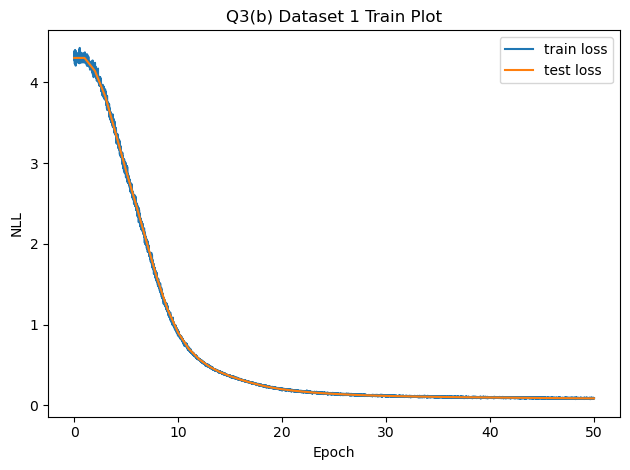

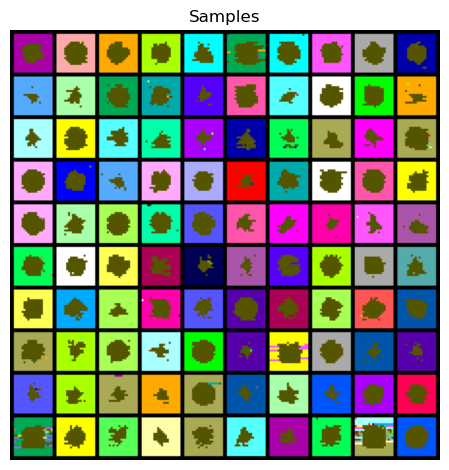

In [147]:
q3ab_save_results(1, 'b', q3_b)

Total number of training steps: 46900


100%|██████████| 157/157 [00:03<00:00, 47.83it/s]


Initial test loss: 4.131


100%|██████████| 157/157 [00:03<00:00, 48.00it/s]


Epoch 1, Train Loss: 4.131, Test Loss: 4.131


100%|██████████| 157/157 [00:03<00:00, 48.05it/s]


Epoch 2, Train Loss: 1.723, Test Loss: 1.038


100%|██████████| 157/157 [00:03<00:00, 48.09it/s]


Epoch 3, Train Loss: 0.915, Test Loss: 0.848


100%|██████████| 157/157 [00:03<00:00, 47.93it/s]


Epoch 4, Train Loss: 0.800, Test Loss: 0.758


100%|██████████| 157/157 [00:03<00:00, 47.83it/s]


Epoch 5, Train Loss: 0.720, Test Loss: 0.684


100%|██████████| 157/157 [00:03<00:00, 47.92it/s]


Epoch 6, Train Loss: 0.656, Test Loss: 0.631


100%|██████████| 157/157 [00:03<00:00, 48.02it/s]


Epoch 7, Train Loss: 0.613, Test Loss: 0.595


100%|██████████| 157/157 [00:03<00:00, 47.98it/s]


Epoch 8, Train Loss: 0.585, Test Loss: 0.573


 35%|███▍      | 327/938 [00:17<00:33, 18.42it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 157/157 [00:03<00:00, 47.82it/s]


Epoch 33, Train Loss: 0.249, Test Loss: 0.250


100%|██████████| 157/157 [00:03<00:00, 47.85it/s]


Epoch 34, Train Loss: 0.241, Test Loss: 0.235


100%|██████████| 157/157 [00:03<00:00, 47.85it/s]


Epoch 35, Train Loss: 0.233, Test Loss: 0.251


100%|██████████| 157/157 [00:03<00:00, 47.85it/s]


Epoch 36, Train Loss: 0.225, Test Loss: 0.220


100%|██████████| 157/157 [00:03<00:00, 47.81it/s]


Epoch 37, Train Loss: 0.219, Test Loss: 0.215


100%|██████████| 157/157 [00:03<00:00, 47.86it/s]


Epoch 38, Train Loss: 0.213, Test Loss: 0.212


100%|██████████| 157/157 [00:03<00:00, 47.84it/s]


Epoch 39, Train Loss: 0.206, Test Loss: 0.203


100%|██████████| 157/157 [00:03<00:00, 47.80it/s]


Epoch 40, Train Loss: 0.200, Test Loss: 0.202


100%|██████████| 157/157 [00:03<00:00, 47.81it/s]


Epoch 41, Train Loss: 0.193, Test Loss: 0.186


100%|██████████| 157/157 [00:03<00:00, 47.82it/s]


Epoch 42, Train Loss: 0.191, Test Loss: 0.182


100%|██████████| 157/157 [00:03<00:00, 47.84it/s]


Epoch 43, Train Loss: 0.184, Test Loss: 0.173


100%|██████████| 157/157 [00:03<00:00, 47.81it/s]


Epoch 44, Train Loss: 0.182, Test Loss: 0.172


100%|██████████| 157/157 [00:03<00:00, 47.82it/s]


Epoch 45, Train Loss: 0.177, Test Loss: 0.165


100%|██████████| 157/157 [00:03<00:00, 47.79it/s]


Epoch 46, Train Loss: 0.179, Test Loss: 0.161


100%|██████████| 157/157 [00:03<00:00, 47.78it/s]


Epoch 47, Train Loss: 0.165, Test Loss: 0.159


100%|██████████| 157/157 [00:03<00:00, 47.81it/s]


Epoch 48, Train Loss: 0.167, Test Loss: 0.154


100%|██████████| 157/157 [00:03<00:00, 47.69it/s]


Epoch 49, Train Loss: 0.172, Test Loss: 0.158


100%|██████████| 157/157 [00:03<00:00, 47.73it/s]


Epoch 50, Train Loss: 0.157, Test Loss: 0.150
Final Test Loss: 0.1501


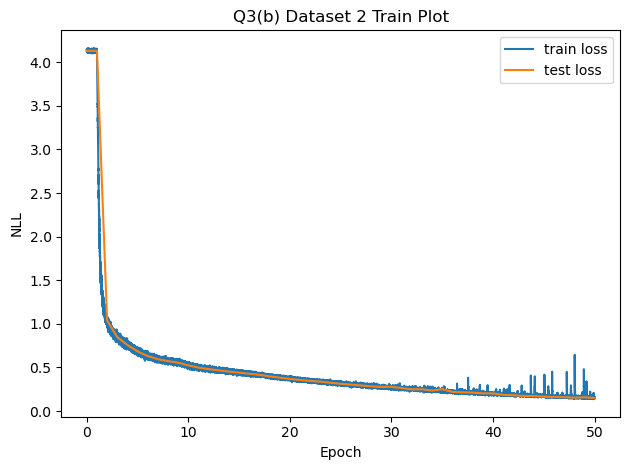

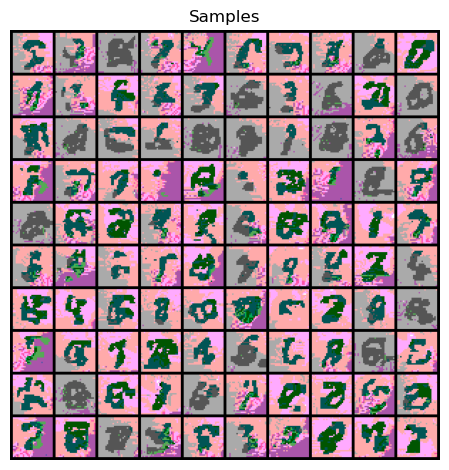

In [77]:
q3ab_save_results(2, 'b', q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.

In [80]:
def q3_c(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets

    Returns
    - a (# sampling steps,) numpy array of time per sampling iteration, without caching
    - a (# sampling steps,) numpy array of time per sampling iteration, with without caching
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated without caching)
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3} (sample generated with caching)
    """
    d_model = 128
    num_heads = 4
    num_layers = 2
    H, W, C = image_shape
    K = 4
    vocab_size = K**C
    max_len = H * W + 1
    num_samples = 100

    state_dict = torch.load('q3_b_dset2_model_with_cache.pt')
    model_no_cache = GPT(
        d_model=d_model, num_layers=num_layers, vocab_size=vocab_size,
        num_heads=num_heads, max_len=max_len, use_cache=False).to(device)
    model_no_cache.load_state_dict(state_dict)
    samples_no_cache, time_list_no_cache = model_no_cache.sample((H, W, C), K, num_samples, return_time=True)
    
    model_with_cache = GPT(
        d_model=d_model, num_layers=num_layers, vocab_size=vocab_size,
        num_heads=num_heads, max_len=max_len, use_cache=True).to(device)
    model_with_cache.load_state_dict(state_dict)
    samples_with_cache, time_list_with_cache = model_with_cache.sample((H, W, C), K, num_samples, return_time=True)
    
    return time_list_no_cache, time_list_with_cache, samples_no_cache, samples_with_cache

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



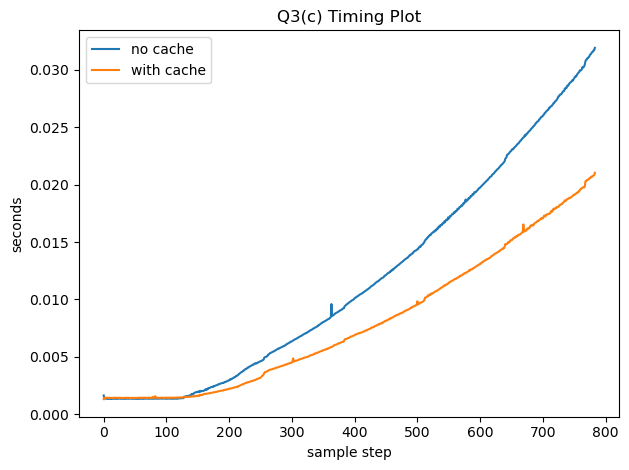

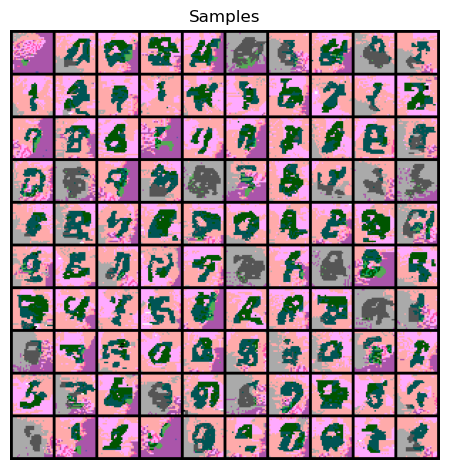

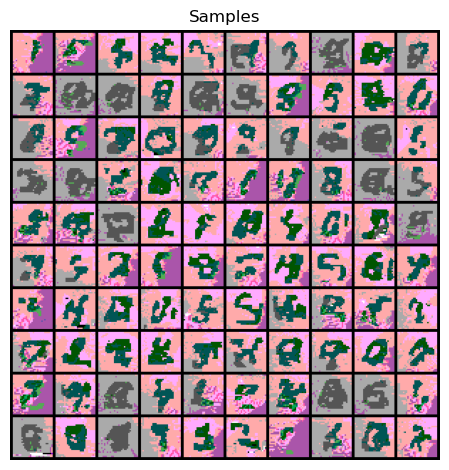

In [81]:
q3c_save_results(2, q3_c)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image.

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience.

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
#

In [168]:
def q4_a(images, vqvae):
    """
    images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a numpy array of size (2, H, W, C) of the decoded image
    """
    
    quantized_images = vqvae.quantize(images)
    autoencoded_images = vqvae.decode(quantized_images)
    return autoencoded_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


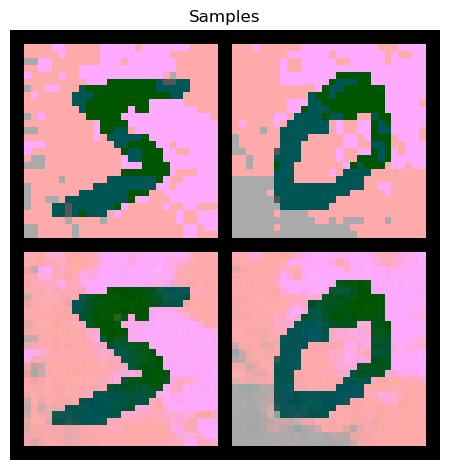

In [169]:
q4a_save_results(1, q4_a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


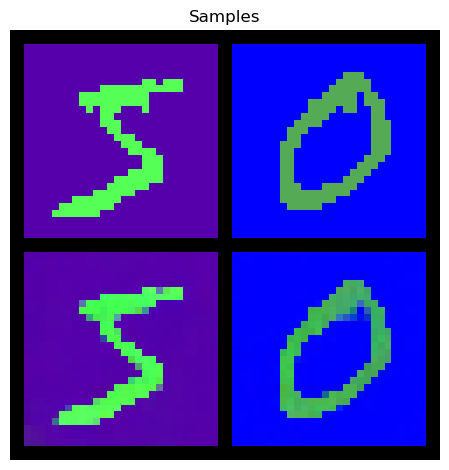

In [170]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

### Q4b Dataset

In [103]:
class VQVAEDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        """
        Args:
            dataset: (N, 7, 7) int numpy array of vqvae qunatized images
                values in [0, 1024)
        """
        super().__init__()
        self.dataset = torch.from_numpy(dataset).to(device)
        
    def __len__(self):
        return self.dataset.shape[0]
    
    def __getitem__(self, idx):
        return self.dataset[idx] # (50,)

    
def vqvae_quantize_dataset(vqvae, images):
    """
    Quantize images with VQVAE in batches then combine
    
    Args:
        vqvae: trained VQVAE
        images: (N, H, W, C)
    """
    batch_size = 2056
    num_images = images.shape[0]
    quantized_images = []
    for start_idx in range(0, num_images, batch_size):
        end_idx = min(start_idx + batch_size, num_images)
        batch = images[start_idx:end_idx] # (B, H, W, C)
        quantized_batch = vqvae.quantize(batch).reshape((batch.shape[0], -1)) # (B, 49)
        bos = np.full((batch.shape[0], 1), vqvae.n_embeddings, dtype=int) # (B, 1)
        quantized_batch = np.concatenate([bos, quantized_batch], axis=1) # (B, 50)
        quantized_images.append(quantized_batch)
    quantized_images = np.concatenate(quantized_images) # (N, 50)
    return quantized_images

### Q4b inference

In [104]:
class GPT_VQVAE(GPT):
    """
    Implements autogressive transformer for VAVAE sampling
    """
    def __init__(
            self, d_model, num_layers, vocab_size, num_heads, 
            max_len, use_cache=True, dropout=0.0):
        super().__init__(d_model, num_layers, vocab_size, num_heads, max_len, use_cache, dropout)

    def sample(self, vqvae, image_shape, num_samples=100):        
        H, W, C = image_shape
        samples = np.zeros((num_samples, H, W, C))

        with torch.no_grad():
            for i in tqdm(range(num_samples)):
                # initialize quantized image with bos
                bos = vqvae.n_embeddings
                x = torch.full((1, 1), bos, device=device)
                cache = None
                # iterate over each pixel
                for pixel_index in range(7 * 7):
                    logits, cache = self.forward(x, cache=cache)
                    # use logits = (1, vocab_size) to sample a single token
                    probs = F.softmax(logits[:, :, -1], dim=-1)
                    # (1, 1)
                    next_token = torch.multinomial(probs, 1)
                    # (1, current_len)
                    x = torch.cat((x, next_token), dim=-1)

                # ignore bos, reshape to (7, 7)
                x = x[:, 1:].view(1, 7, 7)
                # covert quantized image back to image to store in sample tensor
                image = vqvae.decode(x.detach().cpu().numpy())
                samples[i, :, :, :] = image

        return samples

### Q4b train script

In [114]:
def q4_loop(
        loader, model, loss_fn, optimizer=None):
    """
    Training or evaluation loop over all batches
    Pass in a dataloader
    """
    if optimizer:
        model.train()
    else:
        model.eval()

    loss_total = 0
    loss_batches = np.zeros(len(loader))
    
    for i, batch in enumerate(tqdm(loader)):
        if optimizer:
            optimizer.zero_grad()

        logits, _ = model(batch)
        logits = logits[:, :, :-1]
        # shift target by one so the model is predicting the next token
        labels = batch[:, 1:]
        loss = loss_fn(logits, labels)
        # sum of loss of each sample in batch
        loss_total += loss.item() * batch.shape[0]
        loss_batches[i] = loss.item()

        if optimizer:
            loss.backward()
            optimizer.step()

    # mean loss over all samples in the dataset
    loss_total /= len(loader.dataset)
    return loss_total, loss_batches


def q4_b(train_data, test_data, image_shape, dset_id, vqvae):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
           used to set different hyperparameters for different datasets
    vqvae: a vqvae model, trained on dataset dset_id

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
    """
    batch_size = 512
    lr = 1e-2
    num_epochs = 75
    d_model = 128
    num_heads = 4
    num_layers = 4
    warmup_steps = 500
    dropout = 0.1

    H, W, C = image_shape
    vocab_size = vqvae.n_embeddings
    max_len = 50

    model = GPT_VQVAE(
        d_model=d_model, num_layers=num_layers, vocab_size=vocab_size,
        num_heads=num_heads, max_len=max_len, use_cache=True, dropout=dropout).to(device)
    samples = model.sample(vqvae, image_shape, num_samples=5)
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        # tokenize data
        train_loader = torch.utils.data.DataLoader(
            VQVAEDataset(vqvae_quantize_dataset(vqvae, train_data)),
            batch_size=batch_size
        )
        test_loader = torch.utils.data.DataLoader(
            VQVAEDataset(vqvae_quantize_dataset(vqvae, test_data)),
            batch_size=batch_size
        )
        num_batches = len(train_loader)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)
        np.save(f'q4_b_dset{dset_id}_test_loss.npy', test_losses)

        # compute initial test loss
        test_loss, _ = q4_loop(test_loader, model, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    # define optimizer and scheduler
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, 
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q4_loop(train_loader, model, loss_fn, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q4_loop(test_loader, model, loss_fn)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    samples = model.sample(vqvae, image_shape, num_samples=100)
    
    torch.save(model.state_dict(), f'q4_b_dset{dset_id}_model.pt')
    np.save(f'q4_b_dset{dset_id}_test_loss.npy', test_losses)

    train_losses = train_losses.flatten()
    return train_losses, test_losses, samples

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



100%|██████████| 20/20 [00:00<00:00, 150.37it/s]


Initial test loss: 7.104
Total number of training steps: 11800


100%|██████████| 20/20 [00:00<00:00, 144.84it/s]


Epoch 1, Train Loss: 7.105, Test Loss: 7.104


100%|██████████| 20/20 [00:00<00:00, 145.42it/s]


Epoch 2, Train Loss: 6.852, Test Loss: 6.542


100%|██████████| 20/20 [00:00<00:00, 145.76it/s]


Epoch 3, Train Loss: 6.284, Test Loss: 6.086


100%|██████████| 20/20 [00:00<00:00, 145.52it/s]


Epoch 4, Train Loss: 5.927, Test Loss: 5.761


100%|██████████| 20/20 [00:00<00:00, 145.34it/s]


Epoch 5, Train Loss: 5.616, Test Loss: 5.417


100%|██████████| 20/20 [00:00<00:00, 144.26it/s]


Epoch 6, Train Loss: 5.318, Test Loss: 5.179


100%|██████████| 20/20 [00:00<00:00, 144.38it/s]


Epoch 7, Train Loss: 5.118, Test Loss: 4.992


100%|██████████| 20/20 [00:00<00:00, 143.86it/s]


Epoch 8, Train Loss: 4.953, Test Loss: 4.844


100%|██████████| 20/20 [00:00<00:00, 143.74it/s]


Epoch 9, Train Loss: 4.836, Test Loss: 4.747


100%|██████████| 20/20 [00:00<00:00, 143.14it/s]


Epoch 10, Train Loss: 4.754, Test Loss: 4.674


100%|██████████| 20/20 [00:00<00:00, 142.75it/s]


Epoch 11, Train Loss: 4.687, Test Loss: 4.608


100%|██████████| 20/20 [00:00<00:00, 142.63it/s]


Epoch 12, Train Loss: 4.623, Test Loss: 4.542


100%|██████████| 20/20 [00:00<00:00, 142.37it/s]


Epoch 13, Train Loss: 4.557, Test Loss: 4.474


100%|██████████| 20/20 [00:00<00:00, 141.76it/s]


Epoch 14, Train Loss: 4.493, Test Loss: 4.408


100%|██████████| 20/20 [00:00<00:00, 141.95it/s]


Epoch 15, Train Loss: 4.429, Test Loss: 4.342


100%|██████████| 20/20 [00:00<00:00, 141.78it/s]


Epoch 16, Train Loss: 4.364, Test Loss: 4.273


100%|██████████| 20/20 [00:00<00:00, 141.66it/s]


Epoch 17, Train Loss: 4.304, Test Loss: 4.218


100%|██████████| 20/20 [00:00<00:00, 140.51it/s]


Epoch 18, Train Loss: 4.251, Test Loss: 4.168


100%|██████████| 20/20 [00:00<00:00, 141.18it/s]


Epoch 19, Train Loss: 4.203, Test Loss: 4.122


100%|██████████| 20/20 [00:00<00:00, 141.16it/s]


Epoch 20, Train Loss: 4.160, Test Loss: 4.082


100%|██████████| 20/20 [00:00<00:00, 141.01it/s]


Epoch 21, Train Loss: 4.120, Test Loss: 4.042


100%|██████████| 20/20 [00:00<00:00, 140.44it/s]


Epoch 22, Train Loss: 4.081, Test Loss: 4.003


100%|██████████| 20/20 [00:00<00:00, 141.91it/s]


Epoch 23, Train Loss: 4.044, Test Loss: 3.966


100%|██████████| 20/20 [00:00<00:00, 140.76it/s]


Epoch 24, Train Loss: 4.006, Test Loss: 3.928


100%|██████████| 20/20 [00:00<00:00, 140.28it/s]


Epoch 25, Train Loss: 3.971, Test Loss: 3.893


100%|██████████| 20/20 [00:00<00:00, 140.29it/s]


Epoch 26, Train Loss: 3.937, Test Loss: 3.858


100%|██████████| 20/20 [00:00<00:00, 141.09it/s]


Epoch 27, Train Loss: 3.903, Test Loss: 3.825


100%|██████████| 20/20 [00:00<00:00, 140.38it/s]


Epoch 28, Train Loss: 3.870, Test Loss: 3.792


100%|██████████| 20/20 [00:00<00:00, 140.29it/s]


Epoch 29, Train Loss: 3.838, Test Loss: 3.764


100%|██████████| 20/20 [00:00<00:00, 139.47it/s]


Epoch 30, Train Loss: 3.807, Test Loss: 3.729


100%|██████████| 20/20 [00:00<00:00, 140.22it/s]


Epoch 31, Train Loss: 3.776, Test Loss: 3.704


100%|██████████| 20/20 [00:00<00:00, 139.95it/s]


Epoch 32, Train Loss: 3.745, Test Loss: 3.669


100%|██████████| 20/20 [00:00<00:00, 139.36it/s]


Epoch 33, Train Loss: 3.716, Test Loss: 3.644


100%|██████████| 20/20 [00:00<00:00, 139.20it/s]


Epoch 34, Train Loss: 3.688, Test Loss: 3.617


100%|██████████| 20/20 [00:00<00:00, 140.76it/s]


Epoch 35, Train Loss: 3.661, Test Loss: 3.588


100%|██████████| 20/20 [00:00<00:00, 140.29it/s]


Epoch 36, Train Loss: 3.632, Test Loss: 3.567


100%|██████████| 20/20 [00:00<00:00, 139.09it/s]


Epoch 37, Train Loss: 3.608, Test Loss: 3.538


100%|██████████| 20/20 [00:00<00:00, 139.52it/s]


Epoch 38, Train Loss: 3.581, Test Loss: 3.517


100%|██████████| 20/20 [00:00<00:00, 138.78it/s]


Epoch 39, Train Loss: 3.556, Test Loss: 3.492


100%|██████████| 20/20 [00:00<00:00, 139.66it/s]


Epoch 40, Train Loss: 3.533, Test Loss: 3.471


100%|██████████| 20/20 [00:00<00:00, 135.84it/s]


Epoch 41, Train Loss: 3.509, Test Loss: 3.452


100%|██████████| 20/20 [00:00<00:00, 136.42it/s]


Epoch 42, Train Loss: 3.488, Test Loss: 3.432


100%|██████████| 20/20 [00:00<00:00, 137.18it/s]


Epoch 43, Train Loss: 3.467, Test Loss: 3.408


100%|██████████| 20/20 [00:00<00:00, 137.51it/s]


Epoch 44, Train Loss: 3.444, Test Loss: 3.392


100%|██████████| 20/20 [00:00<00:00, 137.56it/s]


Epoch 45, Train Loss: 3.425, Test Loss: 3.368


100%|██████████| 20/20 [00:00<00:00, 138.29it/s]


Epoch 46, Train Loss: 3.406, Test Loss: 3.356


100%|██████████| 20/20 [00:00<00:00, 139.47it/s]


Epoch 47, Train Loss: 3.388, Test Loss: 3.337


100%|██████████| 20/20 [00:00<00:00, 138.29it/s]


Epoch 48, Train Loss: 3.370, Test Loss: 3.321


100%|██████████| 20/20 [00:00<00:00, 139.53it/s]


Epoch 49, Train Loss: 3.353, Test Loss: 3.310


100%|██████████| 20/20 [00:00<00:00, 138.92it/s]


Epoch 50, Train Loss: 3.337, Test Loss: 3.294


100%|██████████| 20/20 [00:00<00:00, 140.04it/s]


Epoch 51, Train Loss: 3.321, Test Loss: 3.278


100%|██████████| 20/20 [00:00<00:00, 139.77it/s]


Epoch 52, Train Loss: 3.306, Test Loss: 3.269


100%|██████████| 20/20 [00:00<00:00, 139.14it/s]


Epoch 53, Train Loss: 3.292, Test Loss: 3.263


100%|██████████| 20/20 [00:00<00:00, 139.45it/s]


Epoch 54, Train Loss: 3.279, Test Loss: 3.245


100%|██████████| 20/20 [00:00<00:00, 139.86it/s]


Epoch 55, Train Loss: 3.265, Test Loss: 3.237


100%|██████████| 20/20 [00:00<00:00, 139.83it/s]


Epoch 56, Train Loss: 3.253, Test Loss: 3.229


100%|██████████| 20/20 [00:00<00:00, 139.31it/s]


Epoch 57, Train Loss: 3.243, Test Loss: 3.217


100%|██████████| 20/20 [00:00<00:00, 140.04it/s]


Epoch 58, Train Loss: 3.230, Test Loss: 3.207


100%|██████████| 20/20 [00:00<00:00, 139.39it/s]


Epoch 59, Train Loss: 3.219, Test Loss: 3.196


100%|██████████| 20/20 [00:00<00:00, 140.11it/s]


Epoch 60, Train Loss: 3.208, Test Loss: 3.185


100%|██████████| 20/20 [00:00<00:00, 139.91it/s]


Epoch 61, Train Loss: 3.197, Test Loss: 3.180


100%|██████████| 20/20 [00:00<00:00, 139.17it/s]


Epoch 62, Train Loss: 3.186, Test Loss: 3.176


100%|██████████| 20/20 [00:00<00:00, 139.77it/s]


Epoch 63, Train Loss: 3.176, Test Loss: 3.164


100%|██████████| 20/20 [00:00<00:00, 139.87it/s]


Epoch 64, Train Loss: 3.167, Test Loss: 3.163


100%|██████████| 20/20 [00:00<00:00, 140.16it/s]


Epoch 65, Train Loss: 3.160, Test Loss: 3.154


100%|██████████| 20/20 [00:00<00:00, 139.81it/s]


Epoch 66, Train Loss: 3.151, Test Loss: 3.150


100%|██████████| 20/20 [00:00<00:00, 140.26it/s]


Epoch 67, Train Loss: 3.144, Test Loss: 3.141


100%|██████████| 20/20 [00:00<00:00, 140.19it/s]


Epoch 68, Train Loss: 3.135, Test Loss: 3.142


100%|██████████| 20/20 [00:00<00:00, 139.69it/s]


Epoch 69, Train Loss: 3.128, Test Loss: 3.132


100%|██████████| 20/20 [00:00<00:00, 140.16it/s]


Epoch 70, Train Loss: 3.120, Test Loss: 3.126


100%|██████████| 20/20 [00:00<00:00, 140.06it/s]


Epoch 71, Train Loss: 3.114, Test Loss: 3.124


100%|██████████| 20/20 [00:00<00:00, 140.00it/s]


Epoch 72, Train Loss: 3.108, Test Loss: 3.115


100%|██████████| 20/20 [00:00<00:00, 140.35it/s]


Epoch 73, Train Loss: 3.102, Test Loss: 3.111


100%|██████████| 20/20 [00:00<00:00, 139.90it/s]


Epoch 74, Train Loss: 3.096, Test Loss: 3.110


100%|██████████| 20/20 [00:00<00:00, 139.75it/s]


Epoch 75, Train Loss: 3.090, Test Loss: 3.100


100%|██████████| 20/20 [00:00<00:00, 140.20it/s]


Epoch 76, Train Loss: 3.085, Test Loss: 3.097


100%|██████████| 20/20 [00:00<00:00, 140.00it/s]


Epoch 77, Train Loss: 3.078, Test Loss: 3.094


100%|██████████| 20/20 [00:00<00:00, 140.31it/s]


Epoch 78, Train Loss: 3.073, Test Loss: 3.089


100%|██████████| 20/20 [00:00<00:00, 139.68it/s]


Epoch 79, Train Loss: 3.068, Test Loss: 3.087


100%|██████████| 20/20 [00:00<00:00, 139.73it/s]


Epoch 80, Train Loss: 3.064, Test Loss: 3.081


100%|██████████| 20/20 [00:00<00:00, 140.09it/s]


Epoch 81, Train Loss: 3.057, Test Loss: 3.077


100%|██████████| 20/20 [00:00<00:00, 139.73it/s]


Epoch 82, Train Loss: 3.053, Test Loss: 3.073


100%|██████████| 20/20 [00:00<00:00, 140.75it/s]


Epoch 83, Train Loss: 3.048, Test Loss: 3.071


100%|██████████| 20/20 [00:00<00:00, 139.39it/s]


Epoch 84, Train Loss: 3.043, Test Loss: 3.068


100%|██████████| 20/20 [00:00<00:00, 140.10it/s]


Epoch 85, Train Loss: 3.038, Test Loss: 3.066


100%|██████████| 20/20 [00:00<00:00, 139.40it/s]


Epoch 86, Train Loss: 3.035, Test Loss: 3.067


100%|██████████| 20/20 [00:00<00:00, 140.49it/s]


Epoch 87, Train Loss: 3.032, Test Loss: 3.060


100%|██████████| 20/20 [00:00<00:00, 139.90it/s]


Epoch 88, Train Loss: 3.028, Test Loss: 3.063


100%|██████████| 20/20 [00:00<00:00, 140.13it/s]


Epoch 89, Train Loss: 3.023, Test Loss: 3.060


100%|██████████| 20/20 [00:00<00:00, 139.79it/s]


Epoch 90, Train Loss: 3.020, Test Loss: 3.058


100%|██████████| 20/20 [00:00<00:00, 140.17it/s]


Epoch 91, Train Loss: 3.017, Test Loss: 3.056


100%|██████████| 20/20 [00:00<00:00, 140.38it/s]


Epoch 92, Train Loss: 3.014, Test Loss: 3.056


100%|██████████| 20/20 [00:00<00:00, 139.88it/s]


Epoch 93, Train Loss: 3.011, Test Loss: 3.052


100%|██████████| 20/20 [00:00<00:00, 140.00it/s]


Epoch 94, Train Loss: 3.008, Test Loss: 3.048


100%|██████████| 20/20 [00:00<00:00, 139.93it/s]


Epoch 95, Train Loss: 3.005, Test Loss: 3.050


100%|██████████| 20/20 [00:00<00:00, 140.19it/s]


Epoch 96, Train Loss: 3.000, Test Loss: 3.048


100%|██████████| 20/20 [00:00<00:00, 140.12it/s]


Epoch 97, Train Loss: 2.999, Test Loss: 3.046


100%|██████████| 20/20 [00:00<00:00, 139.64it/s]


Epoch 98, Train Loss: 2.994, Test Loss: 3.041


100%|██████████| 20/20 [00:00<00:00, 140.48it/s]


Epoch 99, Train Loss: 2.992, Test Loss: 3.040


100%|██████████| 20/20 [00:00<00:00, 140.57it/s]


Epoch 100, Train Loss: 2.991, Test Loss: 3.039


100%|██████████| 100/100 [00:11<00:00,  8.87it/s]


Final Test Loss: 3.0386


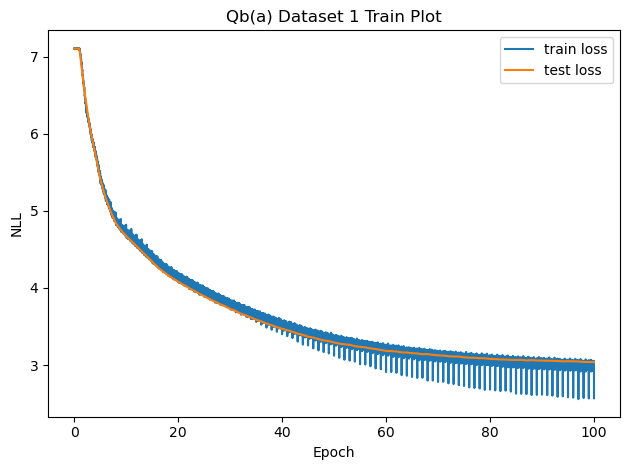

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


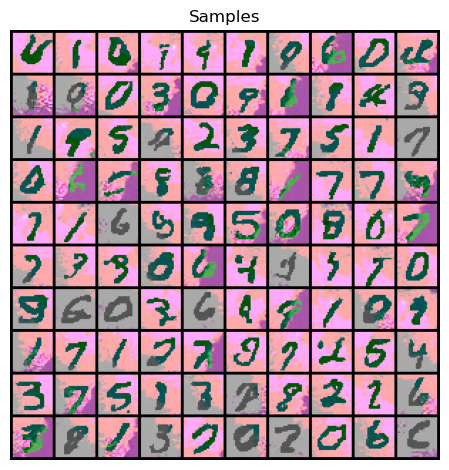

In [111]:
q4b_save_results(1, q4_b)

100%|██████████| 20/20 [00:00<00:00, 149.94it/s]


Initial test loss: 7.106
Total number of training steps: 8850


100%|██████████| 20/20 [00:00<00:00, 144.83it/s]


Epoch 1, Train Loss: 7.105, Test Loss: 7.106


100%|██████████| 20/20 [00:00<00:00, 143.33it/s]


Epoch 2, Train Loss: 6.894, Test Loss: 6.640


100%|██████████| 20/20 [00:00<00:00, 143.83it/s]


Epoch 3, Train Loss: 6.425, Test Loss: 6.244


100%|██████████| 20/20 [00:00<00:00, 143.90it/s]


Epoch 4, Train Loss: 5.980, Test Loss: 5.609


100%|██████████| 20/20 [00:00<00:00, 144.18it/s]


Epoch 5, Train Loss: 5.279, Test Loss: 4.892


100%|██████████| 20/20 [00:00<00:00, 143.05it/s]


Epoch 6, Train Loss: 4.685, Test Loss: 4.425


100%|██████████| 20/20 [00:00<00:00, 142.71it/s]


Epoch 7, Train Loss: 4.352, Test Loss: 4.217


100%|██████████| 20/20 [00:00<00:00, 142.54it/s]


Epoch 8, Train Loss: 4.198, Test Loss: 4.116


100%|██████████| 20/20 [00:00<00:00, 141.86it/s]


Epoch 9, Train Loss: 4.117, Test Loss: 4.056


100%|██████████| 20/20 [00:00<00:00, 141.92it/s]


Epoch 10, Train Loss: 4.065, Test Loss: 4.010


100%|██████████| 20/20 [00:00<00:00, 141.95it/s]


Epoch 11, Train Loss: 4.023, Test Loss: 3.973


100%|██████████| 20/20 [00:00<00:00, 141.25it/s]


Epoch 12, Train Loss: 3.985, Test Loss: 3.934


100%|██████████| 20/20 [00:00<00:00, 141.31it/s]


Epoch 13, Train Loss: 3.948, Test Loss: 3.895


100%|██████████| 20/20 [00:00<00:00, 141.44it/s]


Epoch 14, Train Loss: 3.907, Test Loss: 3.849


100%|██████████| 20/20 [00:00<00:00, 140.77it/s]


Epoch 15, Train Loss: 3.863, Test Loss: 3.803


100%|██████████| 20/20 [00:00<00:00, 140.62it/s]


Epoch 16, Train Loss: 3.818, Test Loss: 3.755


100%|██████████| 20/20 [00:00<00:00, 140.26it/s]


Epoch 17, Train Loss: 3.769, Test Loss: 3.706


100%|██████████| 20/20 [00:00<00:00, 140.67it/s]


Epoch 18, Train Loss: 3.721, Test Loss: 3.658


100%|██████████| 20/20 [00:00<00:00, 140.68it/s]


Epoch 19, Train Loss: 3.676, Test Loss: 3.617


100%|██████████| 20/20 [00:00<00:00, 140.26it/s]


Epoch 20, Train Loss: 3.634, Test Loss: 3.578


100%|██████████| 20/20 [00:00<00:00, 140.50it/s]


Epoch 21, Train Loss: 3.596, Test Loss: 3.546


100%|██████████| 20/20 [00:00<00:00, 139.51it/s]


Epoch 22, Train Loss: 3.561, Test Loss: 3.505


100%|██████████| 20/20 [00:00<00:00, 140.31it/s]


Epoch 23, Train Loss: 3.526, Test Loss: 3.469


100%|██████████| 20/20 [00:00<00:00, 139.97it/s]


Epoch 24, Train Loss: 3.490, Test Loss: 3.433


100%|██████████| 20/20 [00:00<00:00, 139.54it/s]


Epoch 25, Train Loss: 3.456, Test Loss: 3.401


100%|██████████| 20/20 [00:00<00:00, 139.34it/s]


Epoch 26, Train Loss: 3.424, Test Loss: 3.372


100%|██████████| 20/20 [00:00<00:00, 139.46it/s]


Epoch 27, Train Loss: 3.393, Test Loss: 3.340


100%|██████████| 20/20 [00:00<00:00, 140.27it/s]


Epoch 28, Train Loss: 3.365, Test Loss: 3.314


100%|██████████| 20/20 [00:00<00:00, 139.12it/s]


Epoch 29, Train Loss: 3.338, Test Loss: 3.297


100%|██████████| 20/20 [00:00<00:00, 139.90it/s]


Epoch 30, Train Loss: 3.314, Test Loss: 3.273


100%|██████████| 20/20 [00:00<00:00, 139.66it/s]


Epoch 31, Train Loss: 3.289, Test Loss: 3.248


100%|██████████| 20/20 [00:00<00:00, 139.07it/s]


Epoch 32, Train Loss: 3.266, Test Loss: 3.232


100%|██████████| 20/20 [00:00<00:00, 139.09it/s]


Epoch 33, Train Loss: 3.246, Test Loss: 3.213


100%|██████████| 20/20 [00:00<00:00, 138.42it/s]


Epoch 34, Train Loss: 3.226, Test Loss: 3.197


100%|██████████| 20/20 [00:00<00:00, 136.57it/s]


Epoch 35, Train Loss: 3.208, Test Loss: 3.184


100%|██████████| 20/20 [00:00<00:00, 137.08it/s]


Epoch 36, Train Loss: 3.191, Test Loss: 3.169


100%|██████████| 20/20 [00:00<00:00, 134.66it/s]


Epoch 37, Train Loss: 3.175, Test Loss: 3.154


100%|██████████| 20/20 [00:00<00:00, 138.52it/s]


Epoch 38, Train Loss: 3.161, Test Loss: 3.145


100%|██████████| 20/20 [00:00<00:00, 137.00it/s]


Epoch 39, Train Loss: 3.147, Test Loss: 3.130


100%|██████████| 20/20 [00:00<00:00, 138.76it/s]


Epoch 40, Train Loss: 3.133, Test Loss: 3.118


100%|██████████| 20/20 [00:00<00:00, 139.01it/s]


Epoch 41, Train Loss: 3.120, Test Loss: 3.111


100%|██████████| 20/20 [00:00<00:00, 139.09it/s]


Epoch 42, Train Loss: 3.109, Test Loss: 3.105


100%|██████████| 20/20 [00:00<00:00, 139.34it/s]


Epoch 43, Train Loss: 3.097, Test Loss: 3.092


100%|██████████| 20/20 [00:00<00:00, 138.94it/s]


Epoch 44, Train Loss: 3.086, Test Loss: 3.085


100%|██████████| 20/20 [00:00<00:00, 138.70it/s]


Epoch 45, Train Loss: 3.076, Test Loss: 3.079


100%|██████████| 20/20 [00:00<00:00, 139.25it/s]


Epoch 46, Train Loss: 3.067, Test Loss: 3.070


100%|██████████| 20/20 [00:00<00:00, 139.63it/s]


Epoch 47, Train Loss: 3.058, Test Loss: 3.063


100%|██████████| 20/20 [00:00<00:00, 139.29it/s]


Epoch 48, Train Loss: 3.049, Test Loss: 3.057


100%|██████████| 20/20 [00:00<00:00, 139.87it/s]


Epoch 49, Train Loss: 3.041, Test Loss: 3.048


100%|██████████| 20/20 [00:00<00:00, 139.00it/s]


Epoch 50, Train Loss: 3.032, Test Loss: 3.047


100%|██████████| 20/20 [00:00<00:00, 139.43it/s]


Epoch 51, Train Loss: 3.024, Test Loss: 3.044


100%|██████████| 20/20 [00:00<00:00, 139.20it/s]


Epoch 52, Train Loss: 3.016, Test Loss: 3.039


100%|██████████| 20/20 [00:00<00:00, 139.64it/s]


Epoch 53, Train Loss: 3.009, Test Loss: 3.035


100%|██████████| 20/20 [00:00<00:00, 139.85it/s]


Epoch 54, Train Loss: 3.002, Test Loss: 3.030


100%|██████████| 20/20 [00:00<00:00, 139.70it/s]


Epoch 55, Train Loss: 2.996, Test Loss: 3.024


100%|██████████| 20/20 [00:00<00:00, 139.32it/s]


Epoch 56, Train Loss: 2.988, Test Loss: 3.027


100%|██████████| 20/20 [00:00<00:00, 139.73it/s]


Epoch 57, Train Loss: 2.982, Test Loss: 3.018


100%|██████████| 20/20 [00:00<00:00, 140.03it/s]


Epoch 58, Train Loss: 2.976, Test Loss: 3.016


100%|██████████| 20/20 [00:00<00:00, 139.24it/s]


Epoch 59, Train Loss: 2.971, Test Loss: 3.009


100%|██████████| 20/20 [00:00<00:00, 140.09it/s]


Epoch 60, Train Loss: 2.965, Test Loss: 3.008


100%|██████████| 20/20 [00:00<00:00, 139.57it/s]


Epoch 61, Train Loss: 2.960, Test Loss: 2.998


100%|██████████| 20/20 [00:00<00:00, 139.65it/s]


Epoch 62, Train Loss: 2.953, Test Loss: 2.998


100%|██████████| 20/20 [00:00<00:00, 140.11it/s]


Epoch 63, Train Loss: 2.948, Test Loss: 2.998


100%|██████████| 20/20 [00:00<00:00, 139.92it/s]


Epoch 64, Train Loss: 2.943, Test Loss: 2.994


100%|██████████| 20/20 [00:00<00:00, 139.51it/s]


Epoch 65, Train Loss: 2.939, Test Loss: 2.990


100%|██████████| 20/20 [00:00<00:00, 139.93it/s]


Epoch 66, Train Loss: 2.934, Test Loss: 2.986


100%|██████████| 20/20 [00:00<00:00, 140.33it/s]


Epoch 67, Train Loss: 2.928, Test Loss: 2.988


100%|██████████| 20/20 [00:00<00:00, 139.54it/s]


Epoch 68, Train Loss: 2.924, Test Loss: 2.983


100%|██████████| 20/20 [00:00<00:00, 140.41it/s]


Epoch 69, Train Loss: 2.921, Test Loss: 2.987


100%|██████████| 20/20 [00:00<00:00, 140.82it/s]


Epoch 70, Train Loss: 2.916, Test Loss: 2.982


100%|██████████| 20/20 [00:00<00:00, 139.87it/s]


Epoch 71, Train Loss: 2.912, Test Loss: 2.979


100%|██████████| 20/20 [00:00<00:00, 140.10it/s]


Epoch 72, Train Loss: 2.909, Test Loss: 2.978


100%|██████████| 20/20 [00:00<00:00, 139.63it/s]


Epoch 73, Train Loss: 2.905, Test Loss: 2.980


100%|██████████| 20/20 [00:00<00:00, 139.75it/s]


Epoch 74, Train Loss: 2.902, Test Loss: 2.975


100%|██████████| 20/20 [00:00<00:00, 140.68it/s]


Epoch 75, Train Loss: 2.898, Test Loss: 2.976


100%|██████████| 100/100 [00:11<00:00,  8.93it/s]


Final Test Loss: 2.9764


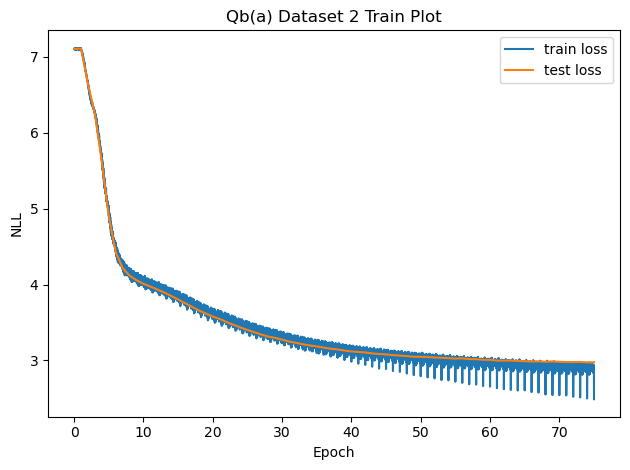

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


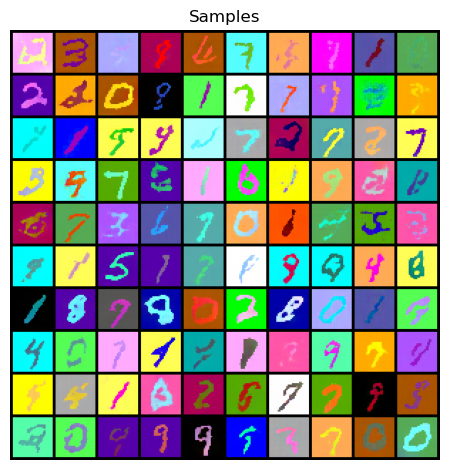

In [115]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [15]:
data = visualize_q5_data()

Sample 1
Blow, blow, thou winter wind,
   Thou art not so unkind
      As mans ingratitude;
   Thy tooth is not so keen,
Because thou art not seen,
      Although thy breath be rude.
Heigh-ho! sing, heigh-ho! unto the green holly:
Most friendship is feigning, most loving mere folly:
   Then, heigh-ho, the holly!
      This life is most jolly.

   Freeze, freeze, thou bitter sky,
   That dost not bite so nigh
      As benefits forgot:
   Though thou the waters warp,
      Thy sting is not so sharp
      As friend remembered not.
Heigh-ho! sing, heigh-ho! unto the green holly...
--------------------------------------------------------------------------------

Sample 2
Ezra Pound, "Canto LXXXI" from The Cantos of Ezra Pound. Copyright  1993 by Ezra Pound. Reprinted by permission of New Directions Publishing Corporation.
--------------------------------------------------------------------------------

Sample 3
Be your words made, good sir, of Indian ware,
That you allow me them by so small

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

### Q5 text tokenizer

In [90]:
class TextTokenizer:
    def __init__(self, text):
        # TODO: put <bos> to the end,
        self.char_to_token = {"<eos>": 0} 
        self.token_to_char = {0: "<eos>"}
        self.vocab_size = 1
        self.build_vocab(text)
    
    def build_vocab(self, text):
        unique_chars = set(char for line in text for char in line if char not in self.char_to_token)
        for char in sorted(unique_chars):  # Sort characters for consistency
            self.char_to_token[char] = self.vocab_size
            self.token_to_char[self.vocab_size] = char
            self.vocab_size += 1
        # add <bos> to dict but not vocab_size
        self.char_to_token["<bos>"] = self.vocab_size
        self.token_to_char[self.vocab_size] = "<bos>" 
    
    def tokenize_text(self, text):
        """
        Returns: list[list[int]]
            each element of the outer list is a text from the input
            each element of the inner list is a character from the text
        """
        tokenized_text = [[self.char_to_token["<bos>"]] + [self.char_to_token[char] for char in line] + [self.char_to_token["<eos>"]] for line in text]
        return tokenized_text
    
    def detokenize_tokens(self, tokens):
        return ''.join(self.token_to_char[token] for token in tokens if token in self.token_to_char)


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, text_dataset, tokenizer, context_length=128):
        """
        Args:
            text_dataset: list[str], text sequences
            tokenizer: TextTokenizer instance
            context_length: int, the fixed size for each subsequence
        """
        self.tokenizer = tokenizer
        self.context_length = context_length
        self.dataset = self.tokenize_and_chunk_text(text_dataset)
    
    def tokenize_and_chunk_text(self, text_dataset):
        # Tokenize the text
        tokenized_text = self.tokenizer.tokenize_text(text_dataset)
        # Break down each tokenized sequence into subsequences of context_length
        # with sliding window size = 1
        subsequences = []
        for sequence in tokenized_text:
            for i in range(0, len(sequence) - self.context_length + 1):
                subsequences.append(sequence[i:i+self.context_length])
        return subsequences
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        subsequence = self.dataset[idx]
        return torch.tensor(subsequence, dtype=torch.long).to(device)

### Q5 inference

In [85]:
class GPTText(GPT):
    """
    Implements autogressive transformer for text sampling
    """
    def __init__(
            self, d_model, num_layers, vocab_size, num_heads, 
            max_len, use_cache=True, dropout=0.0):
        super().__init__(d_model, num_layers, vocab_size, num_heads, max_len, use_cache, dropout)

    def sample(self, tokenizer, num_samples=5, seq_len=128):        
        samples = [''] * num_samples
        eos_token_id = tokenizer.char_to_token['<eos>']

        with torch.no_grad():
            for i in tqdm(range(num_samples)):
                # initialize with <bos>
                x = torch.full((1, 1), tokenizer.char_to_token['<bos>'], device=device)
                cache = None
                # iterate over each character
                for pixel_index in range(seq_len):
                    logits, cache = self.forward(x, cache=cache)
                    # use logits = (1, vocab_size) to sample a single token
                    probs = F.softmax(logits[:, :, -1], dim=-1)
                    # (1, 1)
                    next_token = torch.multinomial(probs, 1)
                    # terminate generation if sampled <eos>
                    if next_token.item() == eos_token_id:
                        break
                    # (1, current_len)
                    x = torch.cat((x, next_token), dim=-1)

                # ignore bos
                x = x[:, 1:]
                # covert back to text
                text = tokenizer.detokenize_tokens([token_id.item() for token_id in x[0]])
                samples[i] = text

        return samples

### Q5 train script

In [101]:
import torch.utils.data as data

def q5_a(train_text, test_text):
    """
    train_text: list[str] Train text sequences.
    test_text: list[str] Test text sequences.

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 5 (str), 5 generated samples from the model.
    """
    batch_size = 2048
    lr = 1e-3
    num_epochs = 50
    d_model = 128
    num_heads = 4
    num_layers = 4
    warmup_steps = 100
    dropout = 0.1
    context_length = 128
    max_len = context_length

    # initialize tokenizer w/ the train dataset
    tokenizer = TextTokenizer(train_text)
    vocab_size = tokenizer.vocab_size

    model = GPTText(
        d_model=d_model, num_layers=num_layers, vocab_size=vocab_size,
        num_heads=num_heads, max_len=max_len, use_cache=True, dropout=dropout).to(device)
    samples = model.sample(tokenizer, num_samples=5)
    loss_fn = nn.CrossEntropyLoss()

    model.eval()
    with torch.no_grad():
        # tokenize data
        train_loader = torch.utils.data.DataLoader(
            TextDataset(train_text, tokenizer, context_length=context_length),
            batch_size=batch_size
        )
        test_loader = torch.utils.data.DataLoader(
            TextDataset(test_text, tokenizer, context_length=context_length),
            batch_size=batch_size
        )
        num_batches = len(train_loader)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q4_loop(test_loader, model, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    # define optimizer and scheduler
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, 
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q4_loop(train_loader, model, loss_fn, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q4_loop(test_loader, model, loss_fn)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()

    # sample from model
    model.eval()
    samples = model.sample(tokenizer, num_samples=5)
    
    torch.save(model.state_dict(), f'q5_a_model.pt')

    train_losses = train_losses.flatten()
    np.save('q5_a_test_loss.npy', test_losses)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



In [102]:
q5a_save_results(q5_a)

100%|██████████| 5/5 [00:00<00:00,  9.79it/s]


Initial test loss: 4.685
Total number of training steps: 11950


100%|██████████| 5/5 [00:00<00:00,  8.99it/s]


Epoch 1, Train Loss: 4.676, Test Loss: 4.685


100%|██████████| 5/5 [00:00<00:00,  9.02it/s]


Epoch 2, Train Loss: 3.949, Test Loss: 3.439


100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


Epoch 3, Train Loss: 3.176, Test Loss: 3.018


100%|██████████| 5/5 [00:00<00:00,  9.09it/s]


Epoch 4, Train Loss: 2.873, Test Loss: 2.741


100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


Epoch 5, Train Loss: 2.677, Test Loss: 2.601


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 6, Train Loss: 2.577, Test Loss: 2.535


100%|██████████| 5/5 [00:00<00:00,  9.02it/s]


Epoch 7, Train Loss: 2.522, Test Loss: 2.495


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 8, Train Loss: 2.486, Test Loss: 2.468


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 9, Train Loss: 2.459, Test Loss: 2.447


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 10, Train Loss: 2.439, Test Loss: 2.431


100%|██████████| 5/5 [00:00<00:00,  9.07it/s]


Epoch 11, Train Loss: 2.423, Test Loss: 2.416


100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


Epoch 12, Train Loss: 2.409, Test Loss: 2.403


100%|██████████| 5/5 [00:00<00:00,  9.05it/s]


Epoch 13, Train Loss: 2.394, Test Loss: 2.386


100%|██████████| 5/5 [00:00<00:00,  9.06it/s]


Epoch 14, Train Loss: 2.375, Test Loss: 2.366


100%|██████████| 5/5 [00:00<00:00,  9.07it/s]


Epoch 15, Train Loss: 2.350, Test Loss: 2.334


100%|██████████| 5/5 [00:00<00:00,  9.01it/s]


Epoch 16, Train Loss: 2.312, Test Loss: 2.294


100%|██████████| 5/5 [00:00<00:00,  9.04it/s]


Epoch 17, Train Loss: 2.264, Test Loss: 2.248


100%|██████████| 5/5 [00:00<00:00,  9.08it/s]


Epoch 18, Train Loss: 2.206, Test Loss: 2.192


 15%|█▌        | 36/239 [00:08<00:48,  4.22it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [112]:
test_losses = np.load('q5_a_test_loss.npy')
test_losses[-1]

1.7035547284290147

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

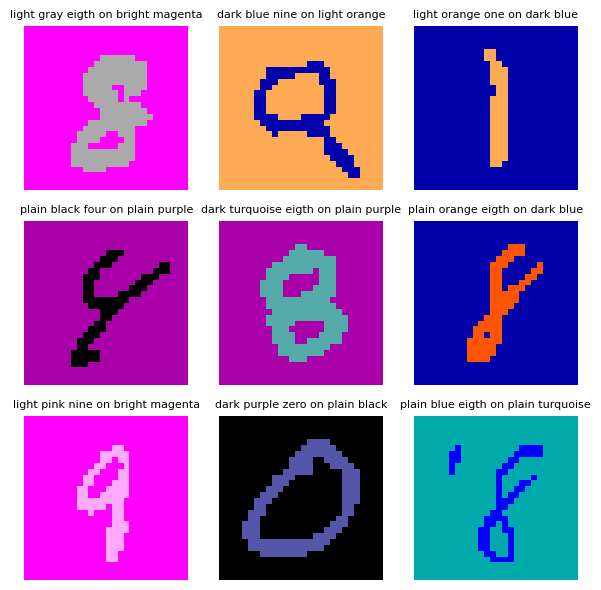

In [297]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves.
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

### Multimodal tokenizer

In [29]:
class MultimodalTokenizer:
    def __init__(self, vqvae, text_eot='<end of text>', image_eot='<end of image>'):
        """
        Initialize the Multimodal Tokenizer without a predefined text vocabulary.
        
        Args:
            vqvae (VQVAETokenizer): An instance of the VQVAE tokenizer for image quantization.
            text_eot (str): Token representing the end of text modality.
            image_eot (str): Token representing the end of image modality.
        """
        self.text_vocab = {}  # Initialize an empty vocabulary
        self.vqvae = vqvae
        self.image_vocab_size = vqvae.n_embeddings  
        # vocab size will be updated after building text vocab
        self.vocab_size = self.image_vocab_size
        self.text_eot = text_eot
        self.image_eot = image_eot
        self.bos = '<bos>'
        self.text_eot_id = None
        self.image_eot_id = None
        self.special_tokens = {}

    def build_text_vocab(self, corpus):
        """
        Build the text vocabulary from a corpus.
        
        Args:
            corpus (list[str]): The corpus to build the vocabulary from, where each item is a text string.
        """
        unique_words = set(word for text in corpus for word in text.split())
        self.text_vocab = {
            word: idx for idx, word in enumerate(unique_words, start=self.image_vocab_size)
        }  # start from image_vocab_size
        
        # update vocab size to include text
        self.vocab_size += len(self.text_vocab) 
        # update special token IDs
        self.text_eot_id = self.vocab_size 
        self.image_eot_id = self.vocab_size + 1
        self.bos_id = self.vocab_size + 2
        # update to include <eos> tokens
        # <bos> doesn't count in vocab size
        # since we never generate it
        self.vocab_size += 2
        
        # Update special tokens mapping
        self.special_tokens = {
            self.bos: self.bos_id,
            self.text_eot: self.text_eot_id,
            self.image_eot: self.image_eot_id
        }
    
    def tokenize_text(self, text_dataset):
        """
        Args:
            text_dataset: list[str], len(N)
        Returns:
            text_tokens: np.ndarray, (N, 6)
        """
        text_tokens = np.vstack([
            np.array([self.text_vocab[word] for word in text.split()], dtype=int)
            for text in text_dataset
        ])
        return text_tokens

    def detokenize_text(self, tokens):
        """
        Reverse lookup in text_vocab to map token back to words
        then join into sentence
        """
        return ' '.join(
            next(word for word, idx in self.text_vocab.items() if idx == token)
            for token in tokens if token in self.text_vocab.values()
        )
    
    def tokenize_image(self, image_dataset):
        """
        Args:
            images: np.ndarray, (N, H, W, C)
        Returns:
            image_tokens: np.ndarray, (N, 49)
        """
        N = image_dataset.shape[0]
        image_tokens = self.vqvae.quantize(image_dataset).reshape((N, -1))
        return image_tokens
    
    
class MultimodalDataset(torch.utils.data.Dataset):
    def __init__(self, tokenizer, text_dataset, image_dataset):
        """
        Args:
            text_dataset: list[str], text sequences
            tokenizer: TextTokenizer instance
            context_length: int, the fixed size for each subsequence
        """
        self.tokenizer = tokenizer
        self.dataset = self.build_dataset(text_dataset, image_dataset)
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        subsequence = self.dataset[idx]
        return torch.tensor(subsequence, dtype=torch.long).to(device)

    def build_dataset(self, text_dataset, image_dataset):
        """
        Returns: np.ndarray
        """
        batch = []
        N = len(text_dataset)
        assert N == image_dataset.shape[0]
        text_tokens = self.tokenizer.tokenize_text(text_dataset)
        image_tokens = self.tokenizer.tokenize_image(image_dataset)
        text_eot = np.full((N//2, 1), self.tokenizer.text_eot_id, dtype=int)
        image_eot = np.full((N//2, 1), self.tokenizer.image_eot_id, dtype=int)
        bos = np.full((N//2, 1), self.tokenizer.bos_id, dtype=int)

        # build dataset with 50/50 splits of image text ordering
        image_first = np.hstack([
            bos, text_eot, image_tokens[:N//2, :], image_eot, text_tokens[:N//2, :]
        ])
        text_first = np.hstack([
            bos, image_eot, text_tokens[N//2:, :], text_eot, image_tokens[N//2:, :]
        ])
        dataset = np.vstack([image_first, text_first])
        return dataset

### Multimodal inference

In [71]:
def sample_images(model, tokenizer, image_shape=(28, 28, 3), num_samples=1, text_prompts=None):
    """
    For multimodal, sample image after <end of text>
    if text_prompts not None, then conditional generation
    else unconditional generation
    """
    H, W, C = image_shape
    conditional = text_prompts is not None
    if conditional:
        num_samples = len(text_prompts)
    samples = []
    image_token_max = tokenizer.image_vocab_size - 1

    with torch.no_grad():
        for i in tqdm(range(num_samples)):
            text_eot = torch.full((1, 1), tokenizer.text_eot_id, device=device)
            if conditional:
                # if conditional, start with tokenized text prompt followed by <end of text>
                prompt = [text_prompts[i]]
                prompt_tokens = torch.from_numpy(tokenizer.tokenize_text(prompt)).to(device) # (1, 6)
                x = torch.cat([prompt_tokens, text_eot], dim=-1) # (1, 7)
            else:
                # if unconditional, start with <end of text>
                x = text_eot
            cache = None
            # iterate over each pixel
            for pixel_index in range(7 * 7):
                logits, cache = model.forward(x, cache=cache)
                # use logits = (1, vocab_size) to sample a single token
                logits = logits[:, :, -1]
                # set all text tokens to -inf before softmax
                # so we only sample image tokens
                is_image_token = torch.ones(tokenizer.vocab_size)
                logits[:, image_token_max+1:] = -1e12
                probs = F.softmax(logits, dim=-1) # (1, 1)
                next_token = torch.multinomial(probs, 1) # (1, 1)
                # (1, current_len)
                x = torch.cat((x, next_token), dim=-1)
            # ignore prompt tokens, reshape to (7, 7)
            # clamp shouldn't be needed after trainiing
            x = x[:, -49:].view(1, 7, 7)
            # covert quantized image back to image to store in sample tensor
            # (28, 28, 3)
            image = tokenizer.vqvae.decode(x.detach().cpu().numpy()).squeeze()
            samples.append(image)
    return samples


def sample_text(model, tokenizer, seq_len=6, num_samples=1, image_prompts=None):
    conditional = image_prompts is not None
    if conditional:
        num_samples = image_prompts.shape[0]
    samples = []
    text_token_min = tokenizer.image_vocab_size
    text_token_max = tokenizer.text_eot_id - 1

    with torch.no_grad():
        for i in tqdm(range(num_samples)):
            image_eot = torch.full((1, 1), tokenizer.image_eot_id, device=device)
            if conditional:
                prompt = image_prompts[i][np.newaxis, ...] # (1, H, W, C)
                # why doesn't this return np.ndarray but tensor?
                prompt_tokens = tokenizer.tokenize_image(prompt).to(device) # (1, 49)
                x = torch.cat([prompt_tokens, image_eot], dim=-1)
            else:
                x = image_eot
            cache = None
            # iterate over each character
            for _ in range(seq_len):
                logits, cache = model.forward(x, cache=cache)
                # use logits = (1, vocab_size) to sample a single token
                logits = logits[:, :, -1]
                # only allow sampling text token
                logits[:, :text_token_min] = -1e12
                logits[:, text_token_max + 1:] = -1e12
                probs = F.softmax(logits, dim=-1) # (1, 1)
                next_token = torch.multinomial(probs, 1) # (1, 1)
                # (1, current_len)
                x = torch.cat((x, next_token), dim=-1)
            # ignore prompt
            x = x[:, -seq_len:]
            # covert back to text
            text = tokenizer.detokenize_text([token_id.item() for token_id in x[0]]) # str
            samples.append(text)
    return samples

    
def sample_unconditional(model, tokenizer, seq_len=6, image_shape=(28, 28, 3), num_samples=1):
    text_eot = tokenizer.text_eot_id
    image_eot = tokenizer.image_eot_id
    samples = []
    with torch.no_grad():
        for i in tqdm(range(num_samples)):
            bos = torch.full((1, 1), tokenizer.bos_id, device=device)
            cache = None
            logits, cache = model.forward(bos, cache=cache)
            logits = logits[:, :, -1]
            # only allow sampling <eot> 
            logits[:, :text_eot] = -1e12
            logits[:, image_eot + 1:] = -1e12
            probs = F.softmax(logits, dim=-1) # (1, 1)
            next_token = torch.multinomial(probs, 1) # (1, 1)
            if next_token == text_eot:
                # sample image prompt, (28, 28, 3)
                image_prompt = sample_images(model, tokenizer)[0]
                # sample text w/ the generated image as prompt
                text = sample_text(model, tokenizer, image_prompts=image_prompt[np.newaxis, ...])[0]
                samples.append((image_prompt, text))
            elif next_token == image_eot:
                # sample text prompt, list[str]
                text_prompt = sample_text(model, tokenizer)
                # sample image w/ the generated text as prompt
                image = sample_images(model, tokenizer, text_prompts=text_prompt)[0]
                samples.append((image, text_prompt[0]))
            else:
                raise ValueError(f'next token {next_token} not <eot>')
    return samples

### Q6 train script

In [ ]:
def q6_a(train_data, test_data, image_shape, train_text, test_text, image_test_prompt, text_test_prompt, vqvae):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
    train_text: list[str] Text data associated with each training image.
    test_text: list[str] Text data associated with each test image.
    image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
    text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 9 (image, text), corresponding to the image conditioned samples
    - a list of 9 (image, text), corresponding to the text conditions samples
    - a list of 9 (image, text), corresponding to unconditional samples
    """
    batch_size = 1024
    lr = 1e-3
    num_epochs = 200
    d_model = 128
    num_heads = 4
    num_layers = 4
    warmup_steps = 100
    dropout = 0.1
    max_len = 60

    # initialize tokenizer w/ the train dataset
    tokenizer = MultimodalTokenizer(vqvae)
    tokenizer.build_text_vocab(train_text)
    vocab_size = tokenizer.vocab_size

    model = GPT(
        d_model=d_model, num_layers=num_layers, vocab_size=vocab_size,
        num_heads=num_heads, max_len=max_len, use_cache=True, dropout=dropout).to(device)

    # unconditional sampling
    samples_unconditioned = sample_unconditional(model, tokenizer, num_samples=9)
    # conditional sampling
    text_samples = sample_text(model, tokenizer, image_prompts=image_test_prompt)
    samples_image_conditioned = [(image_test_prompt[i], text_samples[i]) for i in range(9)]
    image_samples = sample_images(model, tokenizer, text_prompts=text_test_prompt)
    samples_text_conditioned = [(image_samples[i], text_test_prompt[i]) for i in range(9)]
    
    loss_fn = nn.CrossEntropyLoss()
    model.eval()
    with torch.no_grad():
        # tokenize data
        train_loader = torch.utils.data.DataLoader(
            MultimodalDataset(tokenizer, train_text, train_data),
            batch_size=batch_size
        )
        test_loader = torch.utils.data.DataLoader(
            MultimodalDataset(tokenizer, test_text, test_data),
            batch_size=batch_size
        )
        num_batches = len(train_loader)
        train_losses = np.zeros((num_epochs, num_batches))
        test_losses = np.zeros(num_epochs + 1)

        # compute initial test loss
        test_loss, _ = q4_loop(test_loader, model, loss_fn)
        test_losses[0] = test_loss
        print(f'Initial test loss: {test_loss:.3f}')

    # define optimizer and scheduler
    total_steps = num_epochs * num_batches
    print(f'Total number of training steps: {total_steps}')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer, 
        lambda x: lr_lambda(x, warmup_steps=warmup_steps, total_steps=total_steps))

    for epoch in range(num_epochs):
        train_loss, train_loss_batches = q4_loop(train_loader, model, loss_fn, optimizer)
        train_losses[epoch, :] = train_loss_batches
        test_loss, _ = q4_loop(test_loader, model, loss_fn)
        test_losses[epoch + 1] = test_loss
        print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}')
        # lr schedule update for epoch
        scheduler.step()
    train_losses = train_losses.flatten()    
    torch.save(model.state_dict(), f'q6_a_model.pt')

    model.eval()
    # unconditional sampling
    samples_unconditioned = sample_unconditional(model, tokenizer, num_samples=9)
    # conditional sampling
    text_samples = sample_text(model, tokenizer, image_prompts=image_test_prompt)
    samples_image_conditioned = [(image_test_prompt[i], text_samples[i]) for i in range(9)]
    image_samples = sample_images(model, tokenizer, text_prompts=text_test_prompt)
    samples_text_conditioned = [(image_samples[i], text_test_prompt[i]) for i in range(9)]
    
    return train_losses, test_losses, samples_image_conditioned, samples_text_conditioned, samples_unconditioned

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



In [ ]:
q6a_save_results(q6_a)